## Discovering Phone Spam Campaigns

##### Load dataset

In [24]:
%%time

import gzip

data_file = '../datasets/PhoneComplaints/phone_complaints.txt.gz'

complaints_data = dict() # key = tel num, value = list of complaints from that num
c_dict = None # complaint dictionary
with gzip.open(data_file, 'r') as f:
    for line in f:
        l = line.strip()
        
        if len(l) == 0: # empty line
            continue
            
        if l.startswith("####"): # new record found
            if c_dict is not None:
                if c_dict['Tel Number'] not in complaints_data:
                    complaints_data[c_dict['Tel Number']] = []
                complaints_data[c_dict['Tel Number']].append(c_dict)
                # print complaints_data
            c_dict = dict()
            continue # start parsing record
            
        if l.startswith("Record"):
            continue # skip record id
            
        toks = l.split(':')
        if len(toks[0]) < len(l):
            key = toks[0]
            value = l[len(toks[0]):].strip().lstrip(':').strip()
            if key == 'TelL Number':
                key = 'Tel Number' # fix type in raw data
            # print key
            # print value
            c_dict[key] = value



CPU times: user 1min 19s, sys: 1.47 s, total: 1min 21s
Wall time: 1min 21s


###### Create corpus

In [41]:
%%time

from pprint import pprint

MIN_WORDS = 100 # min document length in words

tel_nums = [] # allows for mapping back docs to numbers
docs = []
for n in sorted(complaints_data.keys()):
    # print n
    doc = ''
    for c in complaints_data[n]:
        doc += c['Text'] + ' '
    # print doc
    words = "".join((c if c.isalpha() else " ") for c in doc).split()
    if len(words) >= MIN_WORDS:
        doc = " ".join(words)
        docs.append(doc)
        tel_nums.append(n)

# pprint(docs[0:10])

CPU times: user 1min 42s, sys: 3.38 s, total: 1min 46s
Wall time: 1min 48s


In [74]:
print "Distinct phone numbers in complaints =", len(tel_nums)
print "Number of documents =", len(docs)

Distinct phone numbers in complaints = 21271
Number of documents = 21271


##### Remove stopwords and rare words (likely typos, uninteresting words, etc.)

In [44]:
from collections import defaultdict
from pprint import pprint

## Stopwords from sklearn
## scikit-learn/sklearn/feature_extraction/stop_words.py
#
# This list of English stop words is taken from the "Glasgow Information
# Retrieval Group". The original list can be found at
# http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words
ENGLISH_STOP_WORDS = frozenset([
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
    "yourselves"])

docs_list = [[word for word in d.lower().split() if word not in ENGLISH_STOP_WORDS] for d in docs]
# pprint(docs[0:10])

# remove words that appear only once or that are too short
freq = defaultdict(int)
for d in docs_list:
    for w in d:
        freq[w] += 1
docs_list = [[w for w in d if (freq[w] > 1 and (len(w)>1 and len(w)<20))] for d in docs_list]
# pprint(docs_list[0:2])


[['automated',
  'received',
  'pm',
  'ppi',
  'related',
  'offers',
  'option',
  'say',
  'want',
  'claim',
  'ppi',
  'compensation',
  'ends',
  'chosen',
  'ppi',
  'tps',
  'registered',
  'logged',
  'ico',
  'nuisance',
  'automated',
  'yes',
  'got',
  'appelle',
  'souvent',
  'qu',
  'est',
  'ce',
  'que',
  'est',
  'comme',
  'num',
  'ro',
  'weirdo',
  'fed',
  'calls',
  'ignoring',
  'fed',
  'people',
  'using',
  'valid',
  'phone',
  'numbers',
  'source',
  'message',
  'left',
  'didn',
  'answer',
  'idiots',
  'difference',
  'calls',
  'answer',
  'talk',
  'weirdo',
  'called',
  'did',
  'answer',
  'day',
  'mobile',
  'answered',
  'leave',
  'message',
  'getting',
  'annoying',
  'calls',
  'unknown',
  'just',
  'received',
  'strange',
  'unfamiliarity',
  'strangeness',
  'numbers',
  'did',
  'answer',
  'called',
  'calls',
  'indian',
  'dude',
  'claiming',
  'microsoft',
  'morning',
  'got',
  'unknown',
  'number',
  'just',
  'blew',
  're

  'theft',
  'program',
  'government',
  'ummm',
  'don',
  'think',
  'contacted',
  'police',
  'report',
  'local',
  'police',
  'report',
  'got',
  'calls',
  'number',
  'month',
  'ago',
  'man',
  'indian',
  'accent',
  'stating',
  'lawyer',
  'need',
  'immediately',
  'started',
  'stating',
  'number',
  'stopped',
  'swore',
  'hung',
  'immediately',
  'called',
  'did',
  'thing',
  'left',
  'different',
  'number',
  'said',
  'lawsuits',
  'pending',
  'loan',
  'dollars',
  'took',
  'loan',
  'paid',
  'car',
  'cash',
  'yelled',
  'hung',
  'different',
  'number',
  'indiana',
  'called',
  'said',
  'manager',
  'exact',
  'guy',
  'hung',
  'called',
  'month',
  'later',
  'calling',
  'boyfriend',
  'asking',
  'heck',
  'did',
  'know',
  'live',
  'legal',
  'papers',
  'state',
  'cell',
  'phone',
  'numbers',
  'told',
  'guy',
  'yelled',
  'saying',
  'voicemail',
  'said',
  'different',
  'hung',
  'haven',
  'called',
  'week',
  'got',
  'yester

  'money',
  'work',
  'hard',
  'money',
  'just',
  'like',
  'just',
  'don',
  'understand',
  'getting',
  'away',
  'haven',
  'stopped',
  'feel',
  'sorry',
  'people',
  'actually',
  'gave',
  'money',
  'yesterday',
  'thought',
  'real',
  'know',
  'yall',
  'going',
  'exact',
  'thing',
  'having',
  'problem',
  'numbers',
  'need',
  'report',
  've',
  'called',
  'phone',
  'company',
  'just',
  'offred',
  'change',
  'phone',
  'number',
  'free',
  'lol',
  'calling',
  'job',
  'minutes',
  'calls',
  'exactly',
  'asked',
  'send',
  'proof',
  'deposited',
  'money',
  'account',
  'account',
  'closed',
  'accout',
  'said',
  'considered',
  'defamation',
  'character',
  'repeated',
  'prove',
  'owe',
  'money',
  'pay',
  'course',
  'owe',
  'pay',
  'blocked',
  'number',
  'different',
  'numbers',
  'number',
  'refuse',
  'answer',
  'numbers',
  'don',
  'know',
  'anymore',
  'including',
  'way',
  'number',
  'came',
  'different',
  'person',
  

  'bunch',
  'questions',
  'said',
  'did',
  'research',
  'cops',
  'way',
  'arrest',
  'told',
  'coming',
  'told',
  'guy',
  'come',
  'ha',
  'said',
  'shut',
  'stupid',
  'son',
  'shut',
  'called',
  'number',
  'guy',
  'gave',
  'answered',
  'different',
  'company',
  'messed',
  'guy',
  'went',
  'said',
  'spiderman',
  'number',
  'calls',
  'personal',
  'cell',
  'numbers',
  'night',
  'day',
  'fraud',
  'scam',
  'verify',
  'information',
  'address',
  'workplace',
  'contact',
  'attorney',
  'general',
  'state',
  'attorney',
  'better',
  'business',
  'bureau',
  'fbi',
  'report',
  'said',
  'brandon',
  'mccallum',
  'pretty',
  'funny',
  'middle',
  'eastern',
  'man',
  'maiden',
  'got',
  'came',
  'man',
  'speak',
  'english',
  'looking',
  'father',
  'deceased',
  'years',
  'said',
  'justin',
  'black',
  'left',
  'number',
  'saying',
  'attorney',
  'time',
  'sensitive',
  'matter',
  'total',
  'scammers',
  'lady',
  'just',
  'cus

  'calls',
  'steven',
  'recall',
  'extremely',
  'heavy',
  'indian',
  'accents',
  'leave',
  'message',
  'need',
  'attorney',
  'return',
  'don',
  'return',
  'today',
  'thing',
  'wish',
  'good',
  'luck',
  'planning',
  'taking',
  'use',
  'just',
  'cell',
  'phone',
  'calling',
  'work',
  'called',
  'demanded',
  'stop',
  'calling',
  'secretaries',
  'told',
  'stop',
  'calling',
  'continue',
  'time',
  'spoke',
  'demanded',
  'company',
  'know',
  'law',
  'office',
  'asked',
  'business',
  'license',
  'number',
  'asked',
  'owed',
  'mailed',
  'po',
  'box',
  'screamed',
  'hung',
  'tired',
  'calling',
  'want',
  'stop',
  'don',
  'payday',
  'loans',
  'like',
  'outstanding',
  'filed',
  'complaint',
  'better',
  'business',
  'bureau',
  'oh',
  'funniest',
  'time',
  'called',
  'got',
  'message',
  'saying',
  'magic',
  'jack',
  'customer',
  'set',
  'voicemail',
  'try',
  'later',
  'law',
  'firm',
  'uses',
  'magic',
  'jack',
  

  'disturbance',
  've',
  'received',
  'phone',
  'calls',
  'number',
  'times',
  'evening',
  'let',
  'voicemail',
  'couldn',
  'identify',
  'number',
  'second',
  'time',
  'picked',
  'hear',
  'music',
  'playing',
  'background',
  'hung',
  'getting',
  'pretty',
  'worried',
  'annoyed',
  'im',
  'wondering',
  'wtf',
  'dieing',
  'calls',
  'thiss',
  'said',
  'hello',
  'hello',
  'said',
  'hung',
  'cause',
  'replied',
  'dgtetyuigf',
  'nz',
  'yeah',
  'got',
  'scam',
  'pretend',
  'tsb',
  'bank',
  'answer',
  'acquired',
  'pip',
  'line',
  'steel',
  'number',
  'sell',
  'scum',
  'ignore',
  'number',
  'just',
  'rang',
  'didnt',
  'answer',
  'worried',
  'scam',
  'googling',
  'number',
  'try',
  'lot',
  'office',
  'type',
  'noise',
  'receiver',
  'missed',
  'number',
  'tried',
  'havent',
  'answered',
  'strange',
  'number',
  'circumstances',
  'pickup',
  'answer',
  'type',
  'number',
  'computer',
  'genaerated',
  'calls',
  'scamm

  'giving',
  'husband',
  'couldn',
  'stand',
  'hearing',
  'man',
  'yelling',
  'took',
  'phone',
  'man',
  'finally',
  'got',
  'told',
  'husband',
  'wife',
  'sleeps',
  'town',
  'told',
  'husband',
  'did',
  'sexual',
  'favors',
  'guy',
  'named',
  'roger',
  'frederick',
  'owed',
  'money',
  'lent',
  'husband',
  'told',
  'hindu',
  'lovin',
  'suck',
  'elephant',
  'caller',
  'really',
  'offended',
  'point',
  'asked',
  'husband',
  'work',
  'coming',
  'house',
  'gone',
  'news',
  'red',
  'dot',
  'shoot',
  'gague',
  'bring',
  'wtf',
  'come',
  'owe',
  'time',
  'answer',
  'sing',
  'star',
  'spangled',
  'banner',
  'start',
  'finish',
  'just',
  'got',
  'phone',
  'calls',
  'number',
  'time',
  'called',
  'answered',
  'let',
  'mr',
  'roger',
  'know',
  'reported',
  'calling',
  'earlier',
  'day',
  'bbb',
  'said',
  'report',
  'said',
  'owe',
  'yes',
  'did',
  'hung',
  'know',
  'scams',
  'cuz',
  'guy',
  'barley',
  'spea

  'received',
  'time',
  'sensitive',
  'morning',
  'getting',
  'calls',
  'like',
  'does',
  'good',
  'change',
  'number',
  'issue',
  'exact',
  'company',
  'usa',
  'cash',
  'advance',
  'does',
  'exist',
  'caller',
  'says',
  'company',
  'runs',
  'online',
  'cash',
  'advance',
  'sites',
  'yea',
  'right',
  'called',
  'actual',
  'usa',
  'cash',
  'advance',
  'companies',
  'record',
  'people',
  'said',
  'going',
  'send',
  'new',
  'york',
  'sheriff',
  'door',
  'step',
  'live',
  'indiana',
  'receiving',
  'calls',
  'pick',
  'caller',
  'hangs',
  'does',
  'know',
  'calls',
  'originate',
  'purpose',
  'received',
  'ignored',
  'left',
  'message',
  'received',
  'people',
  'actually',
  'person',
  'number',
  'left',
  'number',
  'calling',
  'week',
  'employees',
  'say',
  'employees',
  'personal',
  'phone',
  'calls',
  'liar',
  'start',
  'screaming',
  'gives',
  'different',
  'strong',
  'indian',
  'accent',
  'wont',
  'tell',


  'dont',
  'wont',
  'unhappy',
  'buggers',
  'sounded',
  'like',
  'slot',
  'machine',
  'calls',
  'ya',
  'background',
  'noise',
  'sounds',
  'happening',
  'alot',
  'people',
  'scam',
  'happened',
  'morning',
  'different',
  'company',
  'companies',
  'wake',
  'scam',
  'changing',
  'got',
  'number',
  'payday',
  'loan',
  'facility',
  'legit',
  'legitimate',
  'payloan',
  'll',
  'tell',
  'scam',
  'll',
  'ask',
  'indian',
  'accents',
  'thing',
  'omg',
  'calling',
  'work',
  'cell',
  'phone',
  'number',
  'harassing',
  'threatening',
  'money',
  'huge',
  'amounts',
  'shame',
  'folks',
  'type',
  'stuff',
  'hard',
  'working',
  'elderly',
  'earth',
  'contacted',
  'scum',
  'bags',
  'calls',
  'sheldon',
  'jackson',
  'gotten',
  'calls',
  'steven',
  'recall',
  'extremely',
  'heavy',
  'indian',
  'accents',
  'leave',
  'message',
  'need',
  'attorney',
  'return',
  'don',
  'return',
  'today',
  'thing',
  'wish',
  'good',
  'luck

  'identify',
  'just',
  'spam',
  'telemarketer',
  'debt',
  'collector',
  'tell',
  'location',
  'came',
  'number',
  'couldn',
  'id',
  'talk',
  'freaky',
  'numbers',
  'blocked',
  'want',
  'numbers',
  'finds',
  'like',
  'let',
  'know',
  'send',
  'message',
  'real',
  'phone',
  'calls',
  'don',
  'work',
  'texts',
  'best',
  'thanks',
  'received',
  'calls',
  'indian',
  'pakistani',
  'scammers',
  'tell',
  'truth',
  'people',
  'corrupt',
  'disgusting',
  'people',
  'world',
  'unfortunently',
  'government',
  'allows',
  'operate',
  'america',
  'practically',
  'taken',
  'control',
  'gasoline',
  'groceries',
  'stores',
  'americas',
  'roadways',
  'getting',
  'away',
  'alot',
  'theft',
  'allowed',
  'govt',
  'exempt',
  'paying',
  'bussiness',
  'taxes',
  'years',
  'fifth',
  'year',
  'comes',
  'transfer',
  'bussiness',
  'indian',
  'pakistani',
  'person',
  'got',
  'calls',
  'tonight',
  'did',
  'answer',
  'caller',
  'suspicio

  'second',
  'gone',
  'australian',
  'number',
  'overseas',
  'yes',
  'new',
  'zealand',
  'got',
  'got',
  'message',
  'saying',
  'holding',
  'weird',
  'rd',
  'contact',
  'pissed',
  'heard',
  'computer',
  'loading',
  'haha',
  'good',
  'kelly',
  'got',
  'answered',
  'time',
  'lady',
  'wanted',
  'reply',
  'yes',
  'questions',
  'fishing',
  'weired',
  'phone',
  'calling',
  'monday',
  'sunday',
  'bkjhj',
  'like',
  'know',
  'came',
  'country',
  'kept',
  'getting',
  'number',
  'sorry',
  'trying',
  'set',
  'account',
  'know',
  'new',
  'micrsoft',
  'phone',
  'yip',
  'got',
  'saying',
  'owe',
  'cash',
  'advance',
  'company',
  'want',
  'hr',
  'going',
  'jail',
  'went',
  'told',
  'didn',
  'told',
  'better',
  'make',
  'phone',
  'calls',
  'scary',
  'info',
  'like',
  'used',
  'work',
  'old',
  'bank',
  'ss',
  'thankful',
  'posts',
  'quick',
  'scam',
  'just',
  'received',
  'showed',
  'man',
  'slight',
  'english',
  '

  'wished',
  'luck',
  'victim',
  'id',
  'theft',
  'times',
  'watch',
  'credit',
  'going',
  'credit',
  'hope',
  'send',
  'police',
  'saying',
  'attorney',
  'area',
  'code',
  'time',
  'supposedly',
  'anderson',
  'california',
  'scam',
  'falling',
  'hope',
  'stops',
  'continue',
  'earfull',
  'ask',
  'speaks',
  'english',
  'gets',
  'tells',
  'theft',
  'program',
  'government',
  'ummm',
  'don',
  'think',
  'contacted',
  'police',
  'report',
  'local',
  'police',
  'report',
  'got',
  'calls',
  'number',
  'month',
  'ago',
  'man',
  'indian',
  'accent',
  'stating',
  'lawyer',
  'need',
  'immediately',
  'started',
  'stating',
  'number',
  'stopped',
  'swore',
  'hung',
  'immediately',
  'called',
  'did',
  'thing',
  'left',
  'different',
  'number',
  'said',
  'lawsuits',
  'pending',
  'loan',
  'dollars',
  'took',
  'loan',
  'paid',
  'car',
  'cash',
  'yelled',
  'hung',
  'different',
  'number',
  'indiana',
  'called',
  'said'

  'defamation',
  'character',
  'repeated',
  'prove',
  'owe',
  'money',
  'pay',
  'course',
  'owe',
  'pay',
  'blocked',
  'number',
  'different',
  'numbers',
  'number',
  'refuse',
  'answer',
  'numbers',
  'don',
  'know',
  'anymore',
  'including',
  'way',
  'number',
  'came',
  'different',
  'person',
  'accent',
  'message',
  'atty',
  'yada',
  'yada',
  'don',
  'think',
  'did',
  'people',
  'posted',
  'numbers',
  'listed',
  'actually',
  'paid',
  'money',
  'world',
  'coming',
  'yeah',
  'knew',
  'strange',
  'number',
  'didn',
  'answer',
  'let',
  'voice',
  'mail',
  'pick',
  'important',
  'just',
  'voice',
  'mail',
  'lady',
  'voice',
  'african',
  'accent',
  'trying',
  'read',
  'script',
  'needing',
  'attorney',
  'funny',
  'lady',
  'calls',
  'julia',
  'smith',
  'tries',
  'obviously',
  'number',
  'country',
  'charge',
  'outrageous',
  'fees',
  'just',
  'minutes',
  'folks',
  'don',
  'suckered',
  'don',
  'jobs',
  'hunte

  'alberta',
  'called',
  'cash',
  'money',
  'confirm',
  'agreed',
  'make',
  'tour',
  'payment',
  'set',
  'new',
  'shows',
  'display',
  'sure',
  'defaulted',
  'loans',
  'couple',
  'today',
  'ignore',
  'answer',
  'second',
  'female',
  'asked',
  'told',
  'wrong',
  'number',
  'think',
  'stop',
  'did',
  'chance',
  'calling',
  'scary',
  'talk',
  'help',
  'rang',
  'midnight',
  'cost',
  'wanted',
  'pay',
  'kept',
  'ringing',
  'just',
  'kept',
  'hanging',
  'said',
  'scream',
  'voice',
  'thing',
  'calls',
  'saying',
  'paid',
  'payday',
  'loan',
  'end',
  'day',
  'pay',
  'arrested',
  'happen',
  'lawyer',
  'retainer',
  'right',
  'called',
  'said',
  'definatly',
  'scam',
  'called',
  'told',
  'legal',
  'representation',
  'told',
  'pay',
  'got',
  'really',
  'rude',
  'insulting',
  'said',
  'nice',
  'day',
  'hung',
  'clowns',
  'salut',
  'sava',
  'fares',
  'just',
  'got',
  'calls',
  'guy',
  'said',
  'calling',
  'cred

  'answering',
  'understand',
  'person',
  'looking',
  'know',
  'told',
  'phone',
  'number',
  'yrs',
  'quit',
  'calling',
  'knowhow',
  'stop',
  'tho',
  'number',
  'like',
  'bad',
  'fine',
  'government',
  'agencies',
  'scam',
  'callers',
  'jail',
  'maybe',
  'working',
  'scam',
  'jail',
  'tell',
  'calling',
  'pls',
  'thanks',
  'got',
  'message',
  'edward',
  'brown',
  'correct',
  'message',
  'stated',
  'handled',
  'legal',
  'matter',
  'called',
  'attempts',
  'wanted',
  'know',
  'settle',
  'debt',
  'let',
  'court',
  'told',
  'contact',
  'company',
  'directly',
  'business',
  'company',
  'stated',
  'believe',
  'scam',
  'got',
  'answer',
  'legal',
  'matter',
  'scam',
  'want',
  'send',
  'money',
  'sue',
  'legal',
  'matters',
  'fact',
  'send',
  'papers',
  'mail',
  'record',
  'changed',
  'number',
  'time',
  'called',
  'different',
  'number',
  'called',
  'work',
  'coworker',
  'early',
  'morning',
  'cause',
  'said

  'professional',
  'anyways',
  'needless',
  'say',
  'monday',
  'came',
  'went',
  'times',
  'haven',
  'gotten',
  'anymore',
  'calls',
  'getting',
  'calls',
  'weeks',
  'day',
  'days',
  'answered',
  'lady',
  'answered',
  'background',
  'noise',
  'accent',
  'couldn',
  'understand',
  'scared',
  'quite',
  'bit',
  'talking',
  'great',
  'urgency',
  'demanding',
  'tell',
  'calls',
  'cell',
  'sick',
  'calls',
  'number',
  'week',
  'debt',
  'agency',
  'owe',
  'hell',
  'just',
  'computer',
  'noise',
  'hangs',
  'computer',
  'generated',
  'dialling',
  'telling',
  'especially',
  'registered',
  'preference',
  'service',
  'joke',
  've',
  'gotten',
  'calls',
  'today',
  'minutes',
  'followed',
  'unknown',
  'caller',
  'hour',
  'won',
  'answer',
  'really',
  'ing',
  'annoying',
  'wtf',
  'rd',
  'contact',
  'got',
  'answered',
  'time',
  'lady',
  'wanted',
  'reply',
  'yes',
  'questions',
  'fishing',
  'weired',
  'phone',
  'callin

  'deal',
  'going',
  'arrested',
  'day',
  'course',
  'police',
  'come',
  'dont',
  'served',
  'legal',
  'notices',
  'phishing',
  'scam',
  'rae',
  'trying',
  'bank',
  'account',
  'info',
  'avoid',
  'arrested',
  'bnot',
  'paying',
  'arrested',
  'paying',
  'illegal',
  'collector',
  'threaten',
  'usually',
  'say',
  'bring',
  'police',
  'good',
  'day',
  'hang',
  'months',
  'way',
  'know',
  'stop',
  'calls',
  'change',
  'number',
  'phone',
  'calls',
  'scam',
  'purchased',
  'numbers',
  'files',
  'number',
  'report',
  'info',
  'false',
  'getting',
  'calls',
  'husband',
  'think',
  'gotten',
  'info',
  'local',
  'car',
  'dealership',
  'applied',
  'loan',
  'years',
  'ago',
  'dealership',
  'went',
  'bankrupt',
  'wondering',
  'sold',
  'people',
  'info',
  'sure',
  'old',
  'work',
  'info',
  'old',
  'address',
  'idea',
  'related',
  'just',
  'bank',
  'account',
  'info',
  'dob',
  'phone',
  'numbers',
  'want',
  'say',
  

  'year',
  'did',
  'answer',
  'yesterday',
  'did',
  'answer',
  'thing',
  'said',
  'attorney',
  'bla',
  'bla',
  'bla',
  'said',
  'let',
  'speak',
  'supervisor',
  'got',
  'phone',
  'sounded',
  'like',
  'exact',
  'guy',
  'wierd',
  'accent',
  'told',
  'thing',
  'told',
  'understand',
  'little',
  'bit',
  'said',
  'pay',
  'somthing',
  'court',
  'pay',
  'ssn',
  'bank',
  'account',
  'number',
  'bank',
  'said',
  'deposited',
  'money',
  'account',
  'went',
  'money',
  'wasn',
  'lawsuit',
  'going',
  'court',
  'police',
  'house',
  'today',
  'address',
  'arrest',
  'couldn',
  'sleep',
  'night',
  'personal',
  'information',
  'really',
  'scared',
  'didn',
  'steal',
  'anyones',
  'money',
  'work',
  'hard',
  'money',
  'just',
  'like',
  'just',
  'don',
  'understand',
  'getting',
  'away',
  'haven',
  'stopped',
  'feel',
  'sorry',
  'people',
  'actually',
  'gave',
  'money',
  'yesterday',
  'thought',
  'real',
  'know',
  'yall

  'cash',
  'advance',
  'said',
  'im',
  'sued',
  'settled',
  'told',
  'heard',
  'company',
  'told',
  'let',
  'know',
  'sue',
  'ready',
  'counter',
  'transferred',
  'guy',
  'indian',
  'accent',
  'sounded',
  'like',
  'drunk',
  'started',
  'asking',
  'speak',
  'supervisor',
  'owing',
  'money',
  'told',
  'illegal',
  'discuss',
  'matters',
  'supervisor',
  'didnt',
  'authorize',
  'started',
  'yelling',
  'laughed',
  'told',
  'send',
  'documentation',
  'asked',
  'contact',
  'info',
  'hung',
  'got',
  'called',
  'said',
  'owed',
  'cash',
  'advace',
  'company',
  'kept',
  'calling',
  'day',
  'finally',
  'pick',
  'couldn',
  'really',
  'understand',
  'indian',
  'accent',
  'ask',
  'true',
  'wanna',
  'paper',
  'denied',
  'said',
  'happen',
  'kept',
  'saying',
  'pay',
  'going',
  'face',
  'court',
  'didn',
  'know',
  'cash',
  'advanced',
  'company',
  'load',
  'make',
  'real',
  'saying',
  'ur',
  'ss',
  'threating',
  'thi

  'enforcement',
  'gave',
  'numbers',
  'given',
  'contact',
  'mainlines',
  'faxes',
  'informed',
  'mr',
  'supervisor',
  'matter',
  'toungetied',
  'promised',
  'make',
  'sure',
  'lose',
  'job',
  'told',
  'boss',
  'matter',
  'thats',
  'going',
  'happen',
  'people',
  'read',
  'said',
  'dont',
  'fall',
  'scam',
  'calls',
  'number',
  'ignoring',
  'letting',
  'voice',
  'mail',
  'voicemails',
  'left',
  'really',
  'starting',
  'annoying',
  'getting',
  'calls',
  'new',
  'zealand',
  'guy',
  'calls',
  'time',
  'called',
  'halfway',
  'dinner',
  'tonight',
  'said',
  'took',
  'loan',
  'deployed',
  'asked',
  'bunch',
  'questions',
  'said',
  'did',
  'research',
  'cops',
  'way',
  'arrest',
  'told',
  'coming',
  'told',
  'guy',
  'come',
  'ha',
  'said',
  'shut',
  'stupid',
  'son',
  'shut',
  'received',
  'calls',
  'indian',
  'pakistani',
  'scammers',
  'tell',
  'truth',
  'people',
  'corrupt',
  'disgusting',
  'people',
  'wo

  'whocallsme',
  'probably',
  'need',
  'blocker',
  'people',
  'harass',
  'mercilessly',
  'post',
  'whocallsme',
  'getting',
  'calls',
  'told',
  'friends',
  'pick',
  'phone',
  'just',
  'picking',
  'phone',
  'cost',
  'money',
  'higher',
  'telephone',
  'told',
  'pick',
  'phone',
  'person',
  'able',
  'start',
  'foreign',
  'country',
  'cost',
  'dont',
  'know',
  'upto',
  'extent',
  'information',
  'true',
  'best',
  'thing',
  'pick',
  'telephone',
  'numbers',
  'thanks',
  'tried',
  'putting',
  'list',
  'stop',
  'people',
  'doing',
  'called',
  'mths',
  'cuss',
  'tell',
  'dont',
  'work',
  'sick',
  'make',
  'stop',
  'just',
  'got',
  'number',
  'rang',
  'hung',
  'bit',
  'odd',
  'holiday',
  'new',
  'zealand',
  'moment',
  'clock',
  'night',
  'yes',
  'police',
  'trace',
  'number',
  'used',
  'program',
  'cover',
  'number',
  'suggest',
  'logging',
  'police',
  'getting',
  'calls',
  'voice',
  'message',
  'left',
  'soun

  'hay',
  'sorry',
  'mist',
  'greece',
  'saturday',
  'morning',
  'calling',
  'number',
  'scary',
  'calling',
  'young',
  'don',
  'know',
  'help',
  'protect',
  'number',
  'hi',
  'philippines',
  'received',
  'morning',
  'did',
  'pick',
  'phone',
  'pls',
  'investigate',
  'access',
  'phone',
  'numbers',
  'think',
  'country',
  'countries',
  'received',
  'today',
  'looks',
  'strange',
  'just',
  'say',
  'hello',
  'seconds',
  'hung',
  'phone',
  'think',
  'caller',
  'want',
  'check',
  'active',
  'know',
  'scam',
  'read',
  'reports',
  'lesson',
  'learned',
  'calls',
  'single',
  'day',
  'speaks',
  'seconds',
  'line',
  'goes',
  'dead',
  'annoying',
  'yea',
  'im',
  'newzealand',
  'bin',
  'ringin',
  'day',
  'hanging',
  'rung',
  'times',
  'today',
  'debt',
  'agency',
  'koz',
  'dnt',
  'debts',
  'wish',
  'tje',
  'clowns',
  'stop',
  'ringing',
  'number',
  'called',
  'response',
  'nd',
  'day',
  'row',
  'ive',
  'missed'

  'today',
  'pm',
  'kept',
  'calling',
  'times',
  'stop',
  'till',
  'answered',
  'cussed',
  'll',
  'fun',
  'bout',
  'change',
  'number',
  'won',
  'let',
  'hung',
  'cuz',
  'went',
  'bad',
  'stupid',
  'stuff',
  'switch',
  'phone',
  'sound',
  'like',
  'indin',
  'abuses',
  'badly',
  'salut',
  'sava',
  'fares',
  'salut',
  'sava',
  'fares',
  'calling',
  'come',
  'hey',
  'man',
  'thats',
  'awsome',
  'reply',
  'thats',
  'ridiculous',
  'don',
  'believe',
  'garbage',
  'got',
  'guy',
  'claimed',
  'officer',
  'named',
  'hardy',
  'going',
  'legal',
  'action',
  'againest',
  'said',
  'company',
  'screaming',
  'yeling',
  'worker',
  'answered',
  'phone',
  'strong',
  'indian',
  'accent',
  'hello',
  'just',
  'received',
  'hit',
  'dismiss',
  'ok',
  'telling',
  'thing',
  'worry',
  'got',
  'oooo',
  'phone',
  'james',
  'mead',
  'threatening',
  'll',
  'pick',
  'jail',
  'called',
  'called',
  'job',
  'don',
  'answer',
  'sc

  'tells',
  'theft',
  'program',
  'government',
  'ummm',
  'don',
  'think',
  'contacted',
  'police',
  'report',
  'local',
  'police',
  'report',
  'got',
  'calls',
  'number',
  'month',
  'ago',
  'man',
  'indian',
  'accent',
  'stating',
  'lawyer',
  'need',
  'immediately',
  'started',
  'stating',
  'number',
  'stopped',
  'swore',
  'hung',
  'immediately',
  'called',
  'did',
  'thing',
  'left',
  'different',
  'number',
  'said',
  'lawsuits',
  'pending',
  'loan',
  'dollars',
  'took',
  'loan',
  'paid',
  'car',
  'cash',
  'yelled',
  'hung',
  'different',
  'number',
  'indiana',
  'called',
  'said',
  'manager',
  'exact',
  'guy',
  'hung',
  'called',
  'month',
  'later',
  'calling',
  'boyfriend',
  'asking',
  'heck',
  'did',
  'know',
  'live',
  'legal',
  'papers',
  'state',
  'cell',
  'phone',
  'numbers',
  'told',
  'guy',
  'yelled',
  'saying',
  'voicemail',
  'said',
  'different',
  'hung',
  'haven',
  'called',
  'week',
  'indi

  'edward',
  'cullen',
  'know',
  'twilight',
  'hung',
  'like',
  'thought',
  'called',
  'boyfriend',
  'answered',
  'bitched',
  'turned',
  'phone',
  'laughed',
  'hard',
  'knew',
  'soooooo',
  'important',
  'called',
  'real',
  'number',
  'people',
  'working',
  'centers',
  'pick',
  'better',
  'hahahahha',
  'yea',
  'gotta',
  'guys',
  'named',
  'harry',
  'wilson',
  'tried',
  'speal',
  'just',
  'hung',
  'think',
  'number',
  'comes',
  'guy',
  'leaves',
  'message',
  'hello',
  'tried',
  'putting',
  'list',
  'stop',
  'people',
  'doing',
  'people',
  'bright',
  'early',
  'everyday',
  'today',
  'decided',
  'said',
  'company',
  'called',
  'state',
  'attorney',
  'taken',
  'payday',
  'loan',
  'took',
  'proceeded',
  'say',
  'sheriff',
  'serving',
  'papers',
  'tomorrow',
  'guess',
  'wait',
  'serve',
  'papers',
  'person',
  'accent',
  'rude',
  've',
  'received',
  'calls',
  'hour',
  'period',
  'foreign',
  'man',
  'claims',
 

  'started',
  'listening',
  'deleted',
  'came',
  'work',
  'today',
  'message',
  'voicemail',
  'work',
  'deleted',
  'going',
  'quite',
  'time',
  'won',
  'hear',
  'couple',
  'months',
  'speak',
  'just',
  'ignore',
  'calls',
  'let',
  'leave',
  'message',
  'rest',
  'assured',
  'tell',
  'leave',
  'don',
  'know',
  'want',
  'threatening',
  'isn',
  'going',
  'listen',
  'process',
  'filing',
  'bankruptcy',
  'maybe',
  'tell',
  'leave',
  'late',
  'couple',
  'payments',
  'payroll',
  'loan',
  'place',
  'alberta',
  'called',
  'cash',
  'money',
  'confirm',
  'agreed',
  'make',
  'tour',
  'payment',
  'set',
  'new',
  'shows',
  'display',
  'sure',
  'defaulted',
  'loans',
  'couple',
  'today',
  'ignore',
  'answer',
  'second',
  'female',
  'asked',
  'told',
  'wrong',
  'number',
  'think',
  'stop',
  'did',
  'chance',
  'calling',
  'scary',
  'talk',
  'help',
  'rang',
  'midnight',
  'cost',
  'wanted',
  'pay',
  'kept',
  'ringing',

  'got',
  'starting',
  'speaking',
  'unrecognized',
  'language',
  'lots',
  'disturbance',
  'vague',
  'inquiries',
  'problem',
  'computer',
  'references',
  'microsoft',
  'support',
  'gentleman',
  'barely',
  'articulate',
  'make',
  'sense',
  'intention',
  'answer',
  'questions',
  'eventually',
  'hung',
  'phone',
  'got',
  'mark',
  'williams',
  'claiming',
  'fbi',
  'said',
  'payday',
  'loan',
  'taken',
  'claimed',
  'going',
  'lawsuit',
  'filed',
  'didn',
  'pay',
  'told',
  'googled',
  'knew',
  'doing',
  'called',
  'times',
  'sent',
  'voice',
  'mail',
  'left',
  'message',
  'telling',
  'direct',
  'line',
  'does',
  'originate',
  'uk',
  'originates',
  'fantastic',
  'country',
  'wonderful',
  'people',
  'uk',
  'scam',
  'different',
  'numbers',
  'fake',
  'calling',
  'work',
  'cell',
  'phone',
  'number',
  'harassing',
  'threatening',
  'money',
  'huge',
  'amounts',
  'shame',
  'folks',
  'type',
  'stuff',
  'hard',
  'work

  'sadly',
  'cell',
  'phone',
  'went',
  'dead',
  'cut',
  'darn',
  'surely',
  'did',
  'need',
  'don',
  'answer',
  'posing',
  'different',
  'groups',
  'agencies',
  'trying',
  'personal',
  'information',
  'know',
  'info',
  'won',
  'good',
  'new',
  'zealand',
  'got',
  'pm',
  'didn',
  'answer',
  'creepy',
  'getting',
  'calls',
  'number',
  'daily',
  'heck',
  'number',
  'calling',
  'phone',
  'sick',
  'calls',
  'day',
  'recently',
  'block',
  'got',
  'morning',
  'mobile',
  'dont',
  'know',
  'comes',
  'getting',
  'calls',
  'number',
  'sick',
  'phone',
  'answer',
  'happy',
  'kinda',
  'scam',
  'number',
  'pick',
  'hang',
  'tired',
  'people',
  'scamming',
  'scamming',
  'don',
  'trust',
  'phone',
  'number',
  'today',
  'foreign',
  'sounding',
  'gentleman',
  'launched',
  'like',
  'talk',
  'car',
  'accident',
  'spiel',
  'quickly',
  'hung',
  'woke',
  'house',
  'midnight',
  'answered',
  'recorded',
  'message',
  'saying

  'got',
  'today',
  'caller',
  'said',
  'going',
  'die',
  'hung',
  'just',
  'reported',
  'minutes',
  'ago',
  'sorry',
  'forgot',
  'mention',
  'live',
  'uk',
  'caller',
  'female',
  'sounded',
  'like',
  'manchester',
  'uk',
  'got',
  'recived',
  'reply',
  'just',
  'got',
  'people',
  'today',
  'randomly',
  'decided',
  'google',
  'indian',
  'accent',
  'number',
  'legal',
  'matter',
  'nice',
  'know',
  'picked',
  'scam',
  'said',
  'going',
  'jail',
  'cyber',
  'currency',
  'crimes',
  'literally',
  'responded',
  'wtf',
  'cyber',
  'currency',
  'crime',
  'response',
  'thing',
  'committed',
  'point',
  'laughed',
  'asked',
  'speak',
  'having',
  'hard',
  'time',
  'understanding',
  'mind',
  've',
  'worked',
  'based',
  'companie',
  'center',
  'outsourced',
  'collections',
  'india',
  'indian',
  'friends',
  'came',
  'standard',
  'line',
  'available',
  'finally',
  'ended',
  'saying',
  'just',
  'stated',
  'wanted',
  'spea

  'named',
  'hardy',
  'going',
  'legal',
  'action',
  'againest',
  'said',
  'company',
  'screaming',
  'yeling',
  'worker',
  'answered',
  'phone',
  'strong',
  'indian',
  'accent',
  'just',
  'received',
  'calls',
  'indian',
  'man',
  'claiming',
  'alex',
  'said',
  'calling',
  'law',
  'firm',
  'needed',
  'confirm',
  'ss',
  'said',
  'allegations',
  'told',
  'contact',
  'police',
  'called',
  'number',
  'keeps',
  'calling',
  'telling',
  'type',
  'court',
  'claim',
  'try',
  'additional',
  'information',
  'like',
  'company',
  'told',
  'quite',
  'listen',
  'dont',
  'know',
  'people',
  'like',
  'help',
  'told',
  'company',
  'untied',
  'care',
  'services',
  'guy',
  'spoke',
  'did',
  'sound',
  'american',
  'barely',
  'understad',
  'receiveing',
  'calls',
  'frist',
  'supposed',
  'collector',
  'officer',
  'scd',
  'leaves',
  'contact',
  'calls',
  'husbands',
  'phone',
  'tells',
  'supposed',
  'charges',
  'face',
  'dont',

  'yesterday',
  'pm',
  'home',
  'number',
  'idk',
  'answeard',
  'black',
  'guy',
  'sayin',
  'ive',
  'heard',
  'youve',
  'talkin',
  'alot',
  'names',
  'joe',
  'hardley',
  'hear',
  'hes',
  'said',
  'like',
  'better',
  'didnt',
  'know',
  'school',
  'called',
  'times',
  'class',
  'phone',
  'vibrate',
  'finnaly',
  'got',
  'home',
  'called',
  'right',
  'sat',
  'hung',
  'voice',
  'message',
  'saying',
  'exact',
  'thing',
  'said',
  'befroe',
  'eventually',
  'later',
  'day',
  'called',
  'house',
  'phone',
  'able',
  'im',
  'getting',
  'calls',
  'completly',
  'random',
  'numbers',
  'voice',
  'recording',
  'help',
  'idk',
  'recived',
  'odd',
  'number',
  'think',
  'number',
  'scam',
  'dont',
  'pick',
  'phone',
  'number',
  'cause',
  'charge',
  'money',
  'guy',
  'called',
  'exact',
  'message',
  'time',
  'changed',
  'justin',
  'brown',
  'bunch',
  'losers',
  'called',
  'times',
  'row',
  'want',
  'threaten',
  'threa

  'took',
  'thier',
  'loan',
  'di',
  'pay',
  'told',
  'bank',
  'statements',
  'prove',
  'didn',
  'said',
  'wouldn',
  'help',
  'lawyer',
  'received',
  'time',
  'sensitive',
  'morning',
  'getting',
  'calls',
  'like',
  'does',
  'good',
  'change',
  'number',
  'yes',
  'scam',
  'applied',
  'payday',
  'loan',
  'mom',
  'got',
  'deaf',
  'handle',
  'phone',
  'calls',
  'times',
  'got',
  'phone',
  'lawyer',
  'listened',
  'voice',
  'mail',
  'lady',
  'named',
  'jessica',
  'angel',
  'asian',
  'accent',
  'gave',
  'stuff',
  'stated',
  've',
  'waiting',
  'ramble',
  'spanish',
  'years',
  'spanish',
  'classes',
  'finally',
  'pay',
  'calls',
  'occassion',
  'talked',
  'brother',
  'fbi',
  'agent',
  'scam',
  'running',
  'uk',
  'got',
  'message',
  'tell',
  'india',
  'hung',
  'calling',
  'calling',
  'scam',
  'trouble',
  'law',
  'getting',
  'calls',
  'months',
  'different',
  'numbers',
  'man',
  'woman',
  'man',
  'claims',
  '

  'looling',
  'barely',
  'understand',
  'stutters',
  'telling',
  'waiting',
  'uk',
  'asked',
  'didnt',
  'understand',
  'reply',
  'asked',
  'did',
  'number',
  'told',
  'facebook',
  'remember',
  'transacts',
  'did',
  'facebook',
  'thats',
  'think',
  'big',
  'scam',
  'sindicate',
  'btw',
  'im',
  'philippines',
  'received',
  'just',
  'silence',
  'ding',
  'sound',
  'followed',
  'woman',
  'voice',
  'kind',
  'automated',
  'services',
  'saying',
  'goodbye',
  'weird',
  'told',
  'scam',
  'info',
  'dont',
  'know',
  'bt',
  'ive',
  'warned',
  'face',
  'book',
  'ansa',
  'number',
  'frm',
  'outside',
  'uk',
  'don',
  'fall',
  'scam',
  'money',
  'just',
  'months',
  'start',
  'harassment',
  'happened',
  'finally',
  'gave',
  'kept',
  'calling',
  'home',
  'work',
  'asking',
  'paid',
  'calls',
  'stopped',
  'just',
  'week',
  'ago',
  'calls',
  'started',
  'did',
  'free',
  'consultation',
  'lawyer',
  'guess',
  'scam',
  'new

  'said',
  'don',
  'pick',
  'people',
  'died',
  'thailand',
  'america',
  'don',
  'pick',
  'number',
  'popped',
  'reminder',
  'unemployment',
  'office',
  'telling',
  'request',
  'payment',
  'got',
  'guy',
  'indian',
  'accent',
  'claiming',
  'officer',
  'regarding',
  'legal',
  'matter',
  'attorney',
  'return',
  'legal',
  'action',
  'taken',
  'wishes',
  'best',
  'luck',
  'um',
  'yeah',
  'ok',
  'think',
  'really',
  'going',
  'indian',
  'guy',
  'claims',
  'officer',
  'sounds',
  'suspicious',
  'hey',
  'company',
  'reading',
  'posts',
  'truly',
  'matter',
  'act',
  'legit',
  'better',
  'response',
  'got',
  'kind',
  'today',
  'claiming',
  'legal',
  'matter',
  'sounds',
  'suspicious',
  'important',
  'real',
  'number',
  'ya',
  'know',
  'number',
  'calls',
  'times',
  'day',
  'finally',
  'answer',
  'guy',
  'harold',
  'vincent',
  'says',
  'pay',
  'usa',
  'cash',
  'advance',
  'heard',
  'company',
  'took',
  'loan',
 

  'heavy',
  'accent',
  'sayin',
  'hes',
  'johnson',
  'sum',
  'kind',
  'law',
  'firm',
  'sayin',
  'lawsuit',
  'ssn',
  'sum',
  'unpaid',
  'loan',
  'believed',
  'cuz',
  'loan',
  'kalls',
  'continued',
  'paid',
  'loan',
  'guy',
  'tryin',
  'worker',
  'supervisor',
  'kan',
  'obviously',
  'tell',
  'person',
  'guy',
  'named',
  'bobby',
  'darling',
  'kalled',
  'cyber',
  'crimes',
  'investigation',
  'harassed',
  'mom',
  'sayin',
  'wuz',
  'trouble',
  'turns',
  'bobby',
  'darling',
  'wuz',
  'guy',
  'kalling',
  'law',
  'firm',
  'really',
  'need',
  'life',
  'received',
  'multiple',
  'calls',
  'guy',
  'couple',
  'days',
  'ago',
  'roger',
  'today',
  'john',
  'things',
  'legal',
  'action',
  'taken',
  'looked',
  'major',
  'scam',
  'news',
  'reports',
  'listed',
  'scam',
  'reported',
  'attorney',
  'general',
  'icc',
  'fbi',
  'told',
  'caller',
  'reported',
  'stop',
  'calling',
  'asked',
  'kind',
  'idiot',
  'answer',
 

  'calls',
  'getting',
  'calls',
  'cell',
  'know',
  'gets',
  'answered',
  'quite',
  'indication',
  'end',
  'human',
  'machine',
  'bf',
  'said',
  'trying',
  'steal',
  'information',
  'don',
  'know',
  'believe',
  'stopped',
  'answering',
  'just',
  'hit',
  'ignore',
  'activity',
  'numbers',
  'texts',
  'calls',
  'real',
  'people',
  'app',
  'bb',
  'ipod',
  'called',
  'mr',
  'numbers',
  'identify',
  'just',
  'spam',
  'telemarketer',
  'debt',
  'collector',
  'tell',
  'location',
  'came',
  'number',
  'couldn',
  'id',
  'talk',
  'freaky',
  'numbers',
  'blocked',
  'want',
  'numbers',
  'finds',
  'like',
  'let',
  'know',
  'send',
  'message',
  'real',
  'phone',
  'calls',
  'don',
  'work',
  'texts',
  'best',
  'thanks',
  'okay',
  'getting',
  'calls',
  'like',
  'months',
  'finally',
  'answered',
  'today',
  'said',
  'want',
  'asked',
  'hung',
  'said',
  'bc',
  'harassing',
  'quit',
  'calling',
  'phone',
  'kn',
  'phone',

  'try',
  'post',
  'later',
  'post',
  'called',
  'past',
  'started',
  'calling',
  'sounded',
  'like',
  'used',
  'voice',
  'recognition',
  'device',
  'alter',
  'voice',
  'good',
  'thing',
  'spoofing',
  'number',
  'expecting',
  'people',
  'using',
  'number',
  'definitely',
  'different',
  'got',
  'morning',
  'wish',
  'tell',
  'person',
  'words',
  'called',
  'total',
  'times',
  'guess',
  'got',
  'tired',
  'calling',
  'stopped',
  'reading',
  'time',
  'absolutely',
  'information',
  'people',
  'obviously',
  'information',
  'calling',
  'number',
  'tell',
  'local',
  'police',
  'station',
  'listening',
  'sure',
  'help',
  'worth',
  'shot',
  'hoping',
  'continue',
  'time',
  'run',
  'police',
  'station',
  'feeling',
  'really',
  'frisky',
  'bond',
  'agents',
  'did',
  'long',
  'time',
  'called',
  'individual',
  'multiple',
  'times',
  'midnight',
  'companies',
  'heard',
  'matter',
  'fact',
  'time',
  'long',
  'time',
  '

  'claim',
  'represent',
  'group',
  'scam',
  'artist',
  'hacked',
  'bank',
  'stole',
  'identifying',
  'information',
  'dont',
  'social',
  'security',
  'number',
  'partial',
  'mailing',
  'address',
  'public',
  'records',
  'information',
  'just',
  'ignore',
  'stop',
  'calling',
  'weeks',
  'time',
  'checked',
  'phone',
  'numbers',
  'dont',
  'dont',
  'worry',
  'scam',
  'stops',
  'working',
  'change',
  'company',
  'names',
  'start',
  'keeps',
  'calling',
  'harrassing',
  'saying',
  'need',
  'attorney',
  'needs',
  'wishes',
  'luck',
  'calls',
  'cell',
  'number',
  'work',
  'number',
  'people',
  'stop',
  'harrassing',
  'sadly',
  'scum',
  'overseas',
  'recognise',
  'number',
  'just',
  'don',
  'answer',
  'tell',
  'works',
  'scam',
  'going',
  'years',
  'ask',
  'got',
  'message',
  'today',
  'foreign',
  'guy',
  'sounds',
  'like',
  'indian',
  'accent',
  'stating',
  'matter',
  'important',
  'attorney',
  'personal',
  'n

  'uk',
  'landline',
  'number',
  'strange',
  'probably',
  'just',
  'scammer',
  'trying',
  'evade',
  'blocking',
  'just',
  'got',
  'number',
  'didn',
  'answer',
  'time',
  'called',
  'bit',
  'later',
  'lady',
  'end',
  'oriental',
  'accent',
  'said',
  'worked',
  'company',
  'govt',
  'wanted',
  'grant',
  'asked',
  'decided',
  'grant',
  'hadn',
  'applied',
  'said',
  'govt',
  'democratic',
  'survey',
  'town',
  'paid',
  'taxes',
  'time',
  'did',
  'criminal',
  'record',
  'came',
  'personal',
  'information',
  'did',
  'want',
  'continue',
  'information',
  'asked',
  'sadly',
  'cell',
  'phone',
  'went',
  'dead',
  'cut',
  'darn',
  'surely',
  'did',
  'need',
  'don',
  'answer',
  'posing',
  'different',
  'groups',
  'agencies',
  'trying',
  'personal',
  'information',
  'know',
  'info',
  'won',
  'good',
  'new',
  'zealand',
  'got',
  'pm',
  'didn',
  'answer',
  'creepy',
  'getting',
  'calls',
  'number',
  'daily',
  'heck',

  'owed',
  'money',
  'payed',
  'try',
  'scam',
  'afternoon',
  'number',
  'lady',
  'sounded',
  'like',
  'spanish',
  'accent',
  'just',
  'said',
  'die',
  'hanging',
  'somewhat',
  'relieved',
  'frustrated',
  'applied',
  'payday',
  'loans',
  'past',
  'assume',
  'sold',
  'information',
  'point',
  'time',
  'address',
  'phone',
  'work',
  'phone',
  'social',
  'security',
  'number',
  'references',
  'americanized',
  'names',
  'use',
  'like',
  'joe',
  'miller',
  'carl',
  'banks',
  'feel',
  'backed',
  'wall',
  'boss',
  'intercepted',
  'calls',
  'work',
  'embarrassing',
  'continually',
  'receive',
  'calls',
  'know',
  've',
  'answered',
  'rec',
  'voice',
  'mail',
  'message',
  'guy',
  'strong',
  'india',
  'accent',
  'saying',
  'attorney',
  'return',
  'wish',
  'good',
  'luck',
  'things',
  'said',
  'issue',
  'hand',
  'time',
  'sensitive',
  'number',
  'called',
  'got',
  'number',
  'phone',
  'rings',
  'non',
  'stop',
  '

  'suspicious',
  'asked',
  'provide',
  'mailing',
  'address',
  'company',
  'documentation',
  'account',
  'just',
  'wanted',
  'number',
  'think',
  'scam',
  'imo',
  'scare',
  'paying',
  'just',
  'received',
  'hit',
  'dismiss',
  'dealing',
  'fools',
  'years',
  'stating',
  'going',
  'court',
  'unpaid',
  'pay',
  'day',
  'loan',
  'needless',
  'say',
  'applied',
  'gets',
  'bad',
  'just',
  'stopped',
  'anwering',
  'phone',
  'today',
  'called',
  'work',
  'national',
  'center',
  'alot',
  'ppl',
  'lady',
  'took',
  'sent',
  'email',
  'manager',
  'person',
  'said',
  'cops',
  'way',
  'arrest',
  'just',
  'laughed',
  'got',
  'embarred',
  'cuz',
  'feel',
  'like',
  'rep',
  'work',
  'tarnished',
  'got',
  'pissed',
  'im',
  'waiting',
  'cell',
  'phone',
  'im',
  'going',
  'hand',
  'husband',
  'started',
  'years',
  'ago',
  'did',
  'worried',
  'called',
  'bank',
  'deposited',
  'claiming',
  'ask',
  'guy',
  'proof',
  'cancel

  'threating',
  'thing',
  'happen',
  'today',
  'told',
  'going',
  'court',
  'loan',
  'took',
  'bring',
  'guess',
  'im',
  'new',
  'zealand',
  'ive',
  'just',
  'got',
  'caller',
  'id',
  'somthing',
  'like',
  'star',
  'shout',
  'makes',
  'pay',
  'charges',
  'guy',
  'said',
  'john',
  'key',
  'said',
  'better',
  'king',
  'anwser',
  'matture',
  'seriously',
  'grow',
  'boys',
  'realise',
  'number',
  'traced',
  'received',
  'oooo',
  'numbers',
  'today',
  'gave',
  'attorney',
  'number',
  'state',
  'attorney',
  'office',
  'number',
  'got',
  'person',
  'saying',
  'legal',
  'matter',
  'dont',
  'settled',
  'tomorrow',
  'court',
  'went',
  'far',
  'say',
  'employeers',
  'number',
  'calling',
  'let',
  'know',
  'matter',
  'type',
  'deal',
  'saying',
  'owe',
  'money',
  'told',
  'ahead',
  'received',
  'left',
  'vm',
  'guy',
  'barely',
  'understand',
  'called',
  'said',
  'department',
  'crime',
  'prevention',
  'called'

  'bank',
  'statements',
  'say',
  'want',
  'submit',
  'sick',
  'es',
  'pay',
  'money',
  'slightest',
  'afraid',
  'court',
  'bring',
  'need',
  'sued',
  'harassment',
  'stalking',
  'law',
  'covers',
  'doing',
  'told',
  'intent',
  'discrimination',
  'let',
  'talk',
  'speaks',
  'legible',
  'english',
  'going',
  'make',
  'threats',
  'guy',
  'claim',
  'officer',
  'david',
  'thing',
  'time',
  'today',
  'total',
  'scam',
  'told',
  'planning',
  'sue',
  'dont',
  'payment',
  'phone',
  'send',
  'papers',
  'court',
  'said',
  'didnt',
  'want',
  'asked',
  'courthouse',
  'said',
  'ummm',
  'total',
  'crapola',
  'dont',
  'just',
  'love',
  'idiots',
  'officer',
  'david',
  'told',
  'didnt',
  'recieve',
  'payment',
  'today',
  'court',
  'tomorrow',
  'told',
  'recieved',
  'service',
  'court',
  'papers',
  'required',
  'law',
  'asked',
  'mail',
  'statement',
  'loan',
  'provide',
  'companies',
  'number',
  'contact',
  'directly

  'thats',
  'fricken',
  'funny',
  'bro',
  'believe',
  'think',
  'anybody',
  'stupid',
  'im',
  'person',
  'calling',
  'run',
  'scamming',
  'team',
  'hahahahaha',
  'hahahahahahahaha',
  'ive',
  'getting',
  'number',
  'calling',
  'weeks',
  'im',
  'new',
  'zealand',
  'times',
  'day',
  'leave',
  'messages',
  'just',
  'received',
  'did',
  'pick',
  'took',
  'advice',
  'uk',
  'just',
  'minute',
  'ago',
  'didn',
  'answer',
  'husband',
  'told',
  'didn',
  'don',
  'left',
  'voice',
  'mail',
  'wear',
  'gonna',
  'received',
  'heavy',
  'accented',
  'indian',
  'women',
  'requesting',
  'speak',
  'grandfather',
  'dead',
  'years',
  'told',
  'regards',
  'conedison',
  'matter',
  'old',
  'discount',
  'blatantly',
  'told',
  'scamming',
  'home',
  'foreign',
  'people',
  'need',
  'stop',
  'calling',
  'needs',
  'harassment',
  'americans',
  'coming',
  'poonjob',
  'report',
  'police',
  'got',
  'calls',
  'times',
  'today',
  'tried',

  'mb',
  'mm',
  'mmmm',
  'mmmmm',
  'mm',
  'mm',
  'mb',
  'bm',
  'bm',
  'bm',
  'bmb',
  'lot',
  'office',
  'type',
  'noise',
  'receiver',
  'saying',
  'sued',
  'owe',
  'money',
  'dont',
  'know',
  'rang',
  'morning',
  'got',
  'today',
  'caller',
  'said',
  'going',
  'die',
  'hung',
  'receiving',
  'calls',
  'number',
  'arfiti',
  'arditi',
  'arifi',
  'calls',
  'answer',
  'hang',
  'starting',
  'nerves',
  'received',
  'called',
  'today',
  'cell',
  'person',
  'didn',
  'say',
  'caller',
  'id',
  'weird',
  'rang',
  'said',
  'going',
  'draw',
  'win',
  'apple',
  'products',
  'got',
  'kind',
  'today',
  'claiming',
  'legal',
  'matter',
  'sounds',
  'suspicious',
  'important',
  'real',
  'number',
  'ya',
  'know',
  'getting',
  'calls',
  'number',
  'went',
  'answer',
  'hung',
  'just',
  'reported',
  'minutes',
  'ago',
  'sorry',
  'forgot',
  'mention',
  'live',
  'uk',
  'caller',
  'female',
  'sounded',
  'like',
  'mancheste

  'accent',
  'did',
  'understand',
  'wanted',
  'wish',
  'luck',
  'did',
  'return',
  'sounded',
  'like',
  'threat',
  'phone',
  'number',
  'asked',
  'called',
  'number',
  'just',
  'rang',
  'went',
  'voicemail',
  'left',
  'message',
  'received',
  'nd',
  'today',
  'answered',
  'phone',
  'sound',
  'voice',
  'end',
  'just',
  'quiet',
  'hung',
  'looked',
  'phone',
  'number',
  'online',
  'connected',
  'scam',
  'company',
  'bay',
  'area',
  'california',
  'don',
  'know',
  'regard',
  'reporting',
  'scam',
  'stopping',
  'calling',
  'does',
  'suggestions',
  'stop',
  'mom',
  'got',
  'number',
  'cell',
  'didn',
  'answer',
  'later',
  'voicemail',
  'man',
  'accent',
  'called',
  'agent',
  'thomas',
  'lee',
  'said',
  'works',
  'fbi',
  'mom',
  'committed',
  'fraud',
  'criminal',
  'acts',
  'guy',
  'needs',
  'hunted',
  'real',
  'fbi',
  'got',
  'thinking',
  'sent',
  'information',
  'thought',
  'transpired',
  'man',
  'said'

  'today',
  'caller',
  'id',
  'shows',
  'leave',
  'message',
  'saying',
  'important',
  'legal',
  'matter',
  'return',
  'door',
  'day',
  'court',
  'court',
  'come',
  'door',
  'number',
  'left',
  'return',
  'today',
  'guy',
  'david',
  'williams',
  'yesterday',
  'number',
  'guy',
  'james',
  'franklen',
  'wont',
  'stop',
  'calling',
  'getting',
  'really',
  'annoyed',
  'rude',
  'answer',
  'phone',
  'don',
  'information',
  'suing',
  'ask',
  'just',
  'say',
  'need',
  'credit',
  'card',
  'information',
  'money',
  'owe',
  'directly',
  'account',
  'don',
  'fall',
  'scam',
  'getting',
  'calls',
  'weeks',
  'say',
  'need',
  'attorney',
  'll',
  'brought',
  'civil',
  'lawsuit',
  'don',
  'pay',
  'loan',
  'company',
  'heard',
  'finally',
  'answered',
  'indian',
  'guy',
  'started',
  'using',
  'word',
  'obsene',
  'words',
  'finally',
  'hung',
  'stopped',
  'just',
  'started',
  'today',
  'stop',
  'craziness',
  'thats',
 

  'talkin',
  'bout',
  'stop',
  'harrasin',
  'getting',
  'calls',
  'weird',
  'number',
  'numbers',
  'appear',
  'bogus',
  'message',
  'left',
  'stating',
  'said',
  'fraud',
  'going',
  'jail',
  'sending',
  'police',
  'attorney',
  'record',
  'return',
  'blah',
  'blah',
  'blah',
  'just',
  'going',
  'ignore',
  'panick',
  'just',
  'company',
  'calling',
  'using',
  'computer',
  'dialer',
  'number',
  'shows',
  'use',
  'systems',
  'guy',
  'calls',
  'time',
  'called',
  'halfway',
  'dinner',
  'tonight',
  'said',
  'took',
  'loan',
  'deployed',
  'asked',
  'bunch',
  'questions',
  'said',
  'did',
  'research',
  'cops',
  'way',
  'arrest',
  'told',
  'coming',
  'told',
  'guy',
  'come',
  'ha',
  'said',
  'shut',
  'stupid',
  'son',
  'shut',
  'called',
  'number',
  'guy',
  'gave',
  'answered',
  'different',
  'company',
  'messed',
  'guy',
  'went',
  'said',
  'spiderman',
  'number',
  'calls',
  'personal',
  'cell',
  'numbers',
 

  'ss',
  'thankful',
  'posts',
  'quick',
  'scam',
  'received',
  'numerous',
  'calls',
  'number',
  'cell',
  'work',
  'phone',
  'scam',
  'research',
  'number',
  'decide',
  'leave',
  'message',
  'sure',
  'complaints',
  'work',
  'government',
  'office',
  'got',
  'police',
  'fbi',
  'involved',
  'yesterday',
  'received',
  'calls',
  'david',
  'careful',
  'getting',
  'information',
  'teletrack',
  'information',
  'used',
  'online',
  'payday',
  'loan',
  'cash',
  'advance',
  'buy',
  'places',
  'including',
  'teletrack',
  'got',
  'relentless',
  'said',
  'owed',
  'cash',
  'advance',
  'asked',
  'speak',
  'company',
  'phone',
  'number',
  'used',
  'payday',
  'loans',
  'told',
  'received',
  'money',
  'company',
  'proof',
  'bank',
  'statements',
  'wouldn',
  'let',
  'word',
  'account',
  'number',
  'closed',
  'months',
  'ago',
  'area',
  'code',
  'story',
  'rest',
  'guy',
  'accent',
  'threatening',
  'arrested',
  'don',
  'pa

  'keeps',
  'ringing',
  'answer',
  'simply',
  'rings',
  'seventies',
  'annoying',
  'stop',
  'got',
  'answered',
  'said',
  'thing',
  'hung',
  'want',
  'know',
  'numbers',
  'blocked',
  've',
  'getting',
  'calls',
  'just',
  'foreign',
  'lots',
  'noise',
  'background',
  'said',
  'calling',
  'car',
  'accident',
  'week',
  'll',
  'clearly',
  'haven',
  'called',
  'said',
  'ppi',
  'replied',
  'don',
  'hung',
  'looks',
  'like',
  'using',
  'son',
  'heather',
  'used',
  'tuck',
  'like',
  'thing',
  'exact',
  'thing',
  'happens',
  'today',
  'tauranga',
  'pm',
  'unknown',
  'apparently',
  'windows',
  'claiming',
  'technical',
  'issues',
  'home',
  'computer',
  'giving',
  'long',
  'reference',
  'identity',
  'asked',
  'switch',
  'computer',
  'suspected',
  'scam',
  'gain',
  'access',
  'computer',
  'declined',
  'got',
  'today',
  'indian',
  'sounding',
  'gentleman',
  'said',
  'worked',
  'behalf',
  'microsoft',
  'inform',
  'c

In [ ]:
# enable logging
import logging
logging.basicConfig(filename='gensim.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [56]:
%%time 

from gensim import corpora
from gensim.models.tfidfmodel import TfidfModel

dictionary = corpora.Dictionary(docs_list)
corpus = [dictionary.doc2bow(doc) for doc in docs_list]
tfidf = TfidfModel(corpus)
corpus_tfidf = []
for d in corpus:
    corpus_tfidf.append(tfidf[d])
    


In [63]:
corpus_tfidf = corpus_tfid
pprint(corpus_tfidf[2])

[(0, 0.047515298240598566),
 (2, 0.09798124742090925),
 (4, 0.019637164190787936),
 (7, 0.025922172992503992),
 (13, 0.05583205588174199),
 (15, 0.02041147082555486),
 (16, 0.02989547103009269),
 (22, 0.01524388101277751),
 (25, 0.08964943459471192),
 (28, 0.020294059589737318),
 (32, 0.03241077534474697),
 (33, 0.04062382082558127),
 (35, 0.05491996370161287),
 (37, 0.06695673141478703),
 (38, 0.02192063276799589),
 (39, 0.020142634524203153),
 (40, 0.01913422278274305),
 (42, 0.04916251344919184),
 (47, 0.07075764987378949),
 (48, 0.015382559424625568),
 (49, 0.03467351906224849),
 (51, 0.04195865538664146),
 (52, 0.06150939502995094),
 (53, 0.05903405906874932),
 (54, 0.03757367049166139),
 (56, 0.02119283935370163),
 (57, 0.010799073598659894),
 (59, 0.03428395339203291),
 (60, 0.023269474681551286),
 (62, 0.01394174949563753),
 (64, 0.009406633251840758),
 (65, 0.040531303963756524),
 (68, 0.027409130970837102),
 (69, 0.022145645846094946),
 (71, 0.027342252107048957),
 (74, 0.026

 (1996, 0.024993383017036356),
 (2000, 0.017749565511944235),
 (2001, 0.012152284364265721),
 (2003, 0.024875175686933836),
 (2005, 0.05382981590469185),
 (2007, 0.01699950144003164),
 (2013, 0.030919615190965737),
 (2016, 0.008003234079506762),
 (2023, 0.03635136337606059),
 (2035, 0.02169642666946832),
 (2038, 0.014991852659892184),
 (2040, 0.020365793285055014),
 (2041, 0.0219886047202944),
 (2048, 0.04714234647842473),
 (2051, 0.022434868945357955),
 (2056, 0.01279729874569477),
 (2062, 0.03449467158191753),
 (2065, 0.01776686870873291),
 (2075, 0.012821974011894815),
 (2076, 0.01631241358725417),
 (2087, 0.019991629967625872),
 (2090, 0.021219291106670122),
 (2094, 0.012637010691501714),
 (2106, 0.036246506285116865),
 (2107, 0.013681290775907079),
 (2108, 0.03148523148228749),
 (2109, 0.010849976011043011),
 (2127, 0.010280068570826943),
 (2149, 0.02211696540763061),
 (2153, 0.011795316981333893),
 (2172, 0.014520965733432568),
 (2174, 0.03407300277678904),
 (2189, 0.013368574165

In [73]:

print "Number of documents =", len(corpus)
print "Number of words = ", len(dictionary.token2id.keys())


Number of documents = 21271
Number of words =  111277


In [117]:
%%time

from gensim.models.ldamodel import LdaModel

NUM_TOPICS = 100

lda1 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=NUM_TOPICS)
lda2 = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=NUM_TOPICS)

lda1.save('../datasets/PhoneComplaints/LDA_'+str(NUM_TOPICS)+'_BOW-phone_complaints.model')
lda2.save('../datasets/PhoneComplaints/LDA_'+str(NUM_TOPICS)+'_TFIDF-phone_complaints.model')

CPU times: user 6min 48s, sys: 17.7 s, total: 7min 5s
Wall time: 7min 15s


##### Show topics and distribution per document

In [108]:
lda1.show_topics(NUM_TOPICS)

In [118]:
lda2.show_topics(NUM_TOPICS)


[(0,
  u'0.013*"publisher" + 0.010*"miami" + 0.006*"traces" + 0.005*"condescending" + 0.004*"mdt" + 0.004*"canyon" + 0.004*"cs" + 0.003*"jdi" + 0.002*"pertinent" + 0.002*"reed"'),
 (1,
  u'0.008*"resume" + 0.005*"heating" + 0.005*"university" + 0.005*"icici" + 0.004*"porn" + 0.003*"echo" + 0.003*"delhi" + 0.003*"tablet" + 0.003*"conference" + 0.003*"vs"'),
 (2,
  u'0.014*"variations" + 0.006*"template" + 0.004*"epp" + 0.004*"brg" + 0.004*"cables" + 0.004*"cockroaches" + 0.003*"swiss" + 0.003*"turkey" + 0.003*"norwegian" + 0.003*"graham"'),
 (3,
  u'0.004*"leasing" + 0.004*"painting" + 0.003*"carlos" + 0.003*"lori" + 0.003*"getaway" + 0.002*"looser" + 0.002*"audi" + 0.002*"fleet" + 0.002*"exploited" + 0.002*"victory"'),
 (4,
  u'0.025*"medicare" + 0.012*"subscription" + 0.010*"magazine" + 0.010*"electric" + 0.009*"supply" + 0.006*"mrs" + 0.006*"emily" + 0.005*"courtesy" + 0.005*"typically" + 0.005*"advertising"'),
 (5,
  u'0.003*"mandatory" + 0.003*"firstsource" + 0.003*"theives" + 0.00

In [120]:
interesting_topic = 95
min_topic_prob = 0.1

for i in xrange(len(corpus)):
    topics_dist = lda2[corpus[i]]
    sorted_topics = sorted(topics_dist, key=lambda x: x[1], reverse=True)
    for (tid,tprob) in sorted_topics:
        if tid == interesting_topic and tprob > min_topic_prob:
            print "=========================="
            print "Phone number =", tel_nums[i]
            print "Topics distribution =", sorted_topics
            print "======= Complaints set index =", i
            print docs[i]

Phone number = 01204719945
Topics distribution = [(17, 0.52199459706116202), (95, 0.27551508100091837), (35, 0.13121912443433745), (15, 0.046808387586223556), (66, 0.016611570247933832)]
======= Complaints set index = 396
How are you mohamed I have travelled to cairo and i will come back on sunday Is yer ouse going to be empty What do you mean yer ouse your house i e Knuckles is wondering whether it ll be safe to call by while you re away so he can break in without fear of being caught Caution best to say nothing or maybe Well while I m away I ve got my brother house sitting as I don t like to put Lucifer into kennels he s a bit bi polar Lucifer not brother well not all the time and can be temperamental and very aggressive with strangers even for a rottweiler Thanks for explaining and don t worry about that its easy How are mr mohamed I hope you are fine Mr Mohamed I am looking for seeing you I am waiting for a chance to see you or at least to hear your voice hi yousef nappy ramadan hi

Phone number = 2022413445
Topics distribution = [(17, 0.56075990259652952), (35, 0.12531092151682674), (95, 0.11704082555608021), (33, 0.072689360166781472), (84, 0.046247901319115631), (49, 0.036199148289022709), (15, 0.017330502076981981)]
======= Complaints set index = 2688
an arrest warrant has been issued in your name IRS is taking legal action against you for trying to defraud IRS same as above an arrest warrant has been issued in your name IRS is taking legal action against you for trying to defraud IRS Caller Claimed to be IRS DISREGARD AND HAND UP Illegally impersonating IRS at AM Illegally impersonating IRS A robot recording threatening that I am going to jail This is crazy You would not believe the amount of scam calls I get now on a daily basis I ve received FOUR of these calls in weeks The IRS must REALLY want me Scamming scum Left no message scam Left message of an arrest warrant issued with my name on it for fraud with the IRS Total scam Automated recording that says the

Phone number = 2026574804
Topics distribution = [(17, 0.83529025712373883), (95, 0.10256073071865771), (35, 0.044827583586177645)]
======= Complaints set index = 2868
Fake IRS Lawsuit scam YES THEY CALLED AND LEFT A GENERIC MESSAGE Got a call with a recorded voice saying they have repeatedly been trying to reach me a lie and that the IRS is filing a law suit against me Same as above recorded voice saying they have been trying to reach me this is my last notice and the IRS is filing a lawsuit against me Hopefully everyone knows the IRS doesn t call they send letters This is what the vm said to me as well Got a message saying there is a lawsuit from the IRS against me Same as above Fake phone call I received the same call from that same number as well So me not knowing the number I sent it to Voicemail and I got a recorded voice message
Phone number = 2026707467
Topics distribution = [(17, 0.71462230003342397), (95, 0.11047831395799004), (15, 0.046282852725333043), (35, 0.045074747653671

Phone number = 2028660715
Topics distribution = [(17, 0.75526045551144383), (95, 0.11886126615812315), (84, 0.036276636764608149), (35, 0.03198676454855133), (98, 0.029099363997647135), (15, 0.015086941591056771)]
======= Complaints set index = 3085
Caller said they represent I RS Said they are with the US Treasury Department regarding tax fraud against me Said they are with the US Treasury Department regarding tax fraud against me Scam Report it https www treasury gov tigta contact report scam shtml just got a call from IRS scam please report it Please beware Got a call from this number and it is a big IRS scam This is the old IRS scam Just ignore or call these criminals and give them false information that will tie up their fraudulent time Got A Call From This number saying i was to respond and if i ignore i would be arrested and have to appear in court You were called by a THIEF in India or Pakistan who spoofs the number Just ignore it The IRS mails letters if there if a problem
Pho

Phone number = 2062380114
Topics distribution = [(17, 0.6006455350549289), (95, 0.13222664689600247), (84, 0.12106819164699925), (35, 0.091936804612987283), (25, 0.017191270662169928), (18, 0.012980933842956189), (6, 0.012469135802475058)]
======= Complaints set index = 3323
Wrong it s a scammer PRETENDING to be the IRS lying to you to get money The IRS DOES NOT CALL Recording says we are being sued by the IRS and should call back for more info they are calling every hour I m ignoring irs is suing me IT S Scamper says I owe money and to call them back Automated call saying I owed the IRS money and they were filing a lawsuit Same call from similar number ending in the day before also reported Recoding stating that the IRS is sueing me Final Notice from IRS that they are filing a lawsuit against me Asked them to verify my address and social number and he said he could not do that I played with this guy so hard I sell timeshare He called the wrong guy lol If they call curse them the hell 

Phone number = 2065650453
Topics distribution = [(17, 0.73452174476453569), (95, 0.14337241786477728), (49, 0.036245774475787376), (35, 0.028366739323736366), (84, 0.027115108128043578), (18, 0.010782255847129886), (85, 0.010202020202046478)]
======= Complaints set index = 3445
This is the second day I ve gotten this call Cant understand the guy whos talking Says he s from the IRS Says if i dont respond have my lawyer call Caller called twice and left a message I filled out a former on IRS Web site about it I have a bookkeeper I know my taxes are good The IRS doesn t call you they will mail you when they want to talk Scam Called he was from IRS that taxes were fraud and to call back and or have ny lawyer call Saying from IRS about taxes to call him Scram he was India voice Guy pretending he is from the IRS Identity thief and scammer This is a fake VoIP number He s been reported to local authorities I better pay money he is from Irs when I asked him for a direct number and extension he 

Phone number = 2105389347
Topics distribution = [(17, 0.72205619204383009), (95, 0.16103966275833373), (84, 0.083238144912267303), (49, 0.016107021147424253), (35, 0.010868838293071786)]
======= Complaints set index = 3733
Called two times today No message left Said for a tax bill wouldn t tell me who they were calling for trying to get my information Scam call IRS scam Officer with the IRS Spam harass people and try to get their info to steal money said I would be arrested if I didn t call back and pay them for tax fraud Claimed to be calling about tax fraud Threatened to arrest me unless I called and gave them money IRS scam Steven Parker from the IRS Threatened to have be arrested if I didn t call back and settle my tax fraud with them Message left on my phone Forwarded voice mail from Tax fraud against you So before this matter goes to the Federal claims court house or before you get arrested Please call immediately on our department number Make sure you call us as soon as possible

Phone number = 2192155277
Topics distribution = [(17, 0.48405199746923405), (95, 0.23450758987354561), (84, 0.11219548499021774), (35, 0.07150351431249749), (15, 0.031154735246247126), (33, 0.01514217167007843), (86, 0.010755546296565246)]
======= Complaints set index = 4336
That the IRS was taking legal action against me The IRS is taking legal action and there is a warrant out for my arrest I can t believe someone is making these calls it s very disheartening Both and called and left the same IRS recording I went to AT T to report these individuals and he saidthere is nothing they can do I guess they pay their bill so no action required Called multiple times leaving voicemails this is the IRS and I m being sued for tax fraud Demanded money over the phone Total scam Originates in either India or Pakistan Block and ignore DO NOT RETURN THE CALL See http www irs gov uac Newsroom IRS Reiterate Telephone ScamSee also https www consumer ftc gov blog scammers continuing pose irs agentsRepor

Phone number = 2679867222
Topics distribution = [(17, 0.68218856413848838), (95, 0.12036741940631109), (35, 0.09693690707497786), (84, 0.022855888545521234), (61, 0.019807137343712512), (39, 0.01980486733939393), (63, 0.019803922033950927)]
======= Complaints set index = 4934
Same here no tax issues but they call wanting to speak with the owner unsure where they got their info but its super annoying when you are trying to run a biz and these people keep calling The company is Ellis Penn They try to solve your tax problems They track you down when there are any tax problems liens filed against you or your business I happen to work someplace where there is an issue but it is being resolved directly through an IRS tax agent That doesn t stop this business or any of the others out there like it from calling daily Same experience These guys are relentless why do they keep calling I have no tax problems what a bunch of
Phone number = 3013071773
Topics distribution = [(17, 0.44957922007169832

Phone number = 3104087714
Topics distribution = [(17, 0.69583797299092398), (95, 0.17550000672789634), (35, 0.052298137007543891), (15, 0.033587150290717217), (18, 0.02692307444109706)]
======= Complaints set index = 5531
automated message from the SCAM IRS Did not know the number they did leave a message Spammer automated message talking about the IRS Keep calling This is the IRS Scammer calling do not engage do not answer do not reply Lying thieving maggots The IRS will never call you EVER They will however send you mail every day but never call or email Scammer calling about IRS law suit against me claiming to be IRS and this is my final warning Same as above phony no pun intended IRS call IRS saying final notice blah blah blah SPAM Trying To scam me IRS scammer Call them back using to block my number and they answer McDonald s may I help you They did not want to deliver my Big Mac and fries Says they are will the IRS Aug at pm I Received call with robovoice message recording saying

Phone number = 3127889891
Topics distribution = [(17, 0.63018392227994591), (95, 0.14192540239928658), (35, 0.096537960232887604), (33, 0.046733155979184454), (84, 0.024811920764104534), (49, 0.013089883533998255), (25, 0.012085110436685925)]
======= Complaints set index = 5724
Did not recognize number on cell Let it go to VM Computerized message left with fake IRS phone call scam No thanks Me too Same day So annoying same here Just got the same call Now blocked Received call on called back and reached what seemed like a cell told to call in minutes when the IRS office is open Didn t recognize phone number let it go to voicemail Scam message from IRS Didn t recognize the number and let it go to VM and it was a computerized system saying that they were from the IRS and an arrest warrant is out in my name and to call them Scam I just got the same call Went to voice mail Computer generated voice threatens wih arrest Same this wrong didn t even ring but had a voice Mail about IRS finally n

Phone number = 3202079187
Topics distribution = [(17, 0.67503705119574986), (95, 0.11892786824124872), (35, 0.083655467287913829), (84, 0.053731715181495776), (49, 0.013416718372904209), (33, 0.012347953833424312), (80, 0.010137382790393718)]
======= Complaints set index = 6084
Another IRS scam threatening me with jail for tax evasion I have been getting these calls daily for a few days now They seem to come In waves I report each one to TIGTA The very first call I got a couple of years ago was a real person with a very heavy Indian accent All of the other dozens of calls have been recordings all with heavy Indian accents I AM SO SICK OF THESE CALLS This is the transcript of the vm these bozos left on my phone The grammar is appalling and hilarious at the same time Hello we have been trying to reach you This call is officially a final notice from IRS internal revenue services The reason of this call is to inform you that IRS is filing lawsuit against you to get more information about t

Phone number = 3234804528
Topics distribution = [(17, 0.59999338066467189), (95, 0.17538159441694606), (84, 0.08336660438693197), (35, 0.059777854951851499), (15, 0.026202098538399686), (33, 0.010161920489656499)]
======= Complaints set index = 6257
Just received a message on my answering machine stating the IRS was filing a law suite not suit against me and I should call their office It sounded like an automated message I got the same exact message from the same phone number did you find out if it was a real thing or just a spam like message Total scam Originates in either India or Pakistan Block and ignore DO NOT RETURN THE CALL See http www irs gov uac Newsroom IRS Reiterate Telephone ScamSee also https www consumer ftc gov blog scammers continuing pose irs agentsReport them https www treasury gov tigta contact report scam shtmlI m an Enrolled Agent with the IRS Inactive IRS does not initiate contacts by phone US mail only IRS does not file lawsuits IRS has enough administrative aut

Phone number = 3309546941
Topics distribution = [(17, 0.53639179490187339), (95, 0.2101970807909822), (84, 0.10092295509370683), (35, 0.070332383898011316), (15, 0.026202954233669567), (33, 0.014012608629486278)]
======= Complaints set index = 6408
IRS scam calls today from IRS informing me IRS is going to sue me calls today Automated message saying the IRS is filing a lawsuit against me and this would be my final notice same phone message as Mark and Bill but number was Told my wife that they had a warrant for her arrest and that she owed back taxes Worked for the IRS and asked for our address This is really funny They are going to arrest you but where do you live They told me they were going to sue me When I asked for paperwork they told me to shut up and I hung up Same as other reports Repeated message IRS is suing me Total scam Originates in either India or Pakistan Block and ignore DO NOT RETURN THE CALL See http www irs gov uac Newsroom IRS Reiterate Telephone ScamSee also https 

Phone number = 3863398531
Topics distribution = [(84, 0.41301378666313648), (35, 0.25221884609469791), (95, 0.21958125284980273), (17, 0.10166498763179843)]
======= Complaints set index = 6955
Claim to be IRS and they are filing a lawsuit against me Another scam Claim to be IRS and they are filing a lawsuit against me Another scam Claim to be IRS and they are filing a lawsuit against me Another scam Claim to be IRS and they are filing a lawsuit against me Another scam Claim to be IRS and they are filing a lawsuit against me Another scam Claim to be IRS and they are filing a lawsuit against me Another scam Claim to be IRS and they are filing a lawsuit against me Another scam Claim to be IRS and they are filing a lawsuit against me Another scam Claim to be IRS and they are filing a lawsuit against me Another scam Claim to be IRS and they are filing a lawsuit against me Another scam Claim to be IRS and they are filing a lawsuit against me Another scam Claim to be IRS and they are filing a

Phone number = 4192169539
Topics distribution = [(17, 0.64287984229499895), (84, 0.10216378339392582), (95, 0.10029640704514928), (33, 0.095437279053994059), (35, 0.040286802269104249), (15, 0.010150839213852183)]
======= Complaints set index = 7975
I missed call from this number and I didn t answer the phone at the time they left a voicemail stating that I was going to be arrested I called the number back three times and someone just sat on the phone and didn t say anything I could hear people talking IRS Scam Recorded message that arrest warrant is issued IRS scam scam Scam call IRS has an arrest warrant Exact same message also came in from irs scam call IRS scam call Said legal action will be taken for what Got calls yesterday from the same state threatening jail time IRS scam Threatened legal action IRS scam call Same recording different number called twice the day before called re an issued warrant for my arrest Got a call from supposed IRS stating a warrant for my arrest was issu

Phone number = 4422435972
Topics distribution = [(17, 0.72077488939830414), (95, 0.10205650340134421), (84, 0.057092888874419122), (35, 0.050589721030354952), (33, 0.025699106869568607), (49, 0.010515108604864336)]
======= Complaints set index = 8365
Said IRS fraud setting up to issue arrest warrant for me IRS scam thick accent Called at w caller ID Victorville CA No message left except for a few seconds of what sounded like the ambience of a busy call center Just called No message left I won t answer if i don t know who you are Man with heavy middle eastern accent stated he was calling from mail order pharmacy Wanted to know what drugs I used When I said he should know them he stated that I needed refills And I could pay for them with my credit card I hung up Had the same thing happen on No message Listed as Victorville CA called asked if I took meds sounded like busy call center BLOCKED calls seconds apart Silence for a couple seconds so I hung up no one I know called received call f

Phone number = 5072623735
Topics distribution = [(17, 0.69131951883162956), (33, 0.16844616783363434), (95, 0.10235111546669708), (84, 0.021612011427363759)]
======= Complaints set index = 9066
I ignored the call I just received a call from this number saying a warrant has been issued for my arrest Can t call it back Left recorded message saying IRS Iis waiting for a call back Left recorded message saying IRS Iis waiting for a call back Tried calling it back got hung up on This isn t the first call I ve received from this number I received a call from stating that a warrant arrest for tax fraud IRS warrant for arrest call back Warren for arrest from irs called as IRS has a Warrenton for arrest This was about the th call today I received calls from both those numbers saying same thing about to call back I believe it to be Scammers It was a RECORDED CALLER MESSAGE
Phone number = 5092074100
Topics distribution = [(17, 0.76052734027052959), (95, 0.1120506743797666), (35, 0.0271660829630754

Phone number = 5202103612
Topics distribution = [(17, 0.6806099802696618), (95, 0.11359333449593076), (35, 0.053791500216195554), (84, 0.045452840255455908), (15, 0.041083811852560742), (33, 0.025519785803356471)]
======= Complaints set index = 9728
Received a phone call from this number No message left My friend received a phone call from this number they said they were from the IRS and demanding payment she called told them that they were scamming and hung up on them I just got the same call her name was Nancy lol So did i Also Nancy I just got a call from this number Said they were from the IRS and were going to put me jail IT IS A SCAM My friend Andrea received a phone call from this number they were threatening to put her in jail said they were from the IRS that they were going to restroom she did not pay over to them immediately she told them they were scamming and hung the phone up on them Said from IRS to avoid arrest from local police called me and threatened jail and that the

Phone number = 5402051188
Topics distribution = [(17, 0.53935289754716986), (95, 0.20727464802885004), (84, 0.07447885189770441), (35, 0.074474451285452853), (15, 0.03160474650595186), (33, 0.021881468256908166)]
======= Complaints set index = 9838
This phone number left me a bogus message claiming to be from the IRS Stated they had filed a law suit against me Bogus Yea they got me They said a warrant was issued my bank account would be seized my license revoked If I wanted to stop the warrant I would have to pay minimum of Ugh I was freaking out Just hang up the phone if it happens to you I ve heard if you don t pay someone calls you pretending to be local police Total scam Originates in either India or Pakistan Block and ignore DO NOT RETURN THE CALL See http www irs gov uac Newsroom IRS Reiterate Telephone ScamSee also https www consumer ftc gov blog scammers continuing pose irs agentsReport them https www treasury gov tigta contact report scam shtmlI m an Enrolled Agent with the IR

Phone number = 5622429638
Topics distribution = [(17, 0.67946499052720333), (95, 0.101318034762964), (84, 0.08610457419859395), (49, 0.049691402241531978), (35, 0.044075252275986958), (99, 0.013479076934668226), (55, 0.013466669059052283)]
======= Complaints set index = 10076
Claims to be from the IRS but he sure isn t in the United States He heard language that would make a sailor blush Claim to be IRS filing a lawsuit today They claim to be from IRS and if I didn t pay now I would be taken to jail today Voice mail is in female voice claiming to be the irs filing a lawsuit against me Friend of mine got the exact same Claims to be the IRS stating this is my final notice and I m having a lawsuit filed against me I was curious when I called on another line there is a message that says a bugs ate our phones New number old scam If you talk to them they ll say you several thousand dollars in over due taxes and are about to be arrested You can avoid arrest by paying off those taxes right thi

Phone number = 6092010678
Topics distribution = [(17, 0.61292631279737597), (95, 0.12139890910480033), (33, 0.098315342029802577), (35, 0.088731565443099777), (15, 0.021327296086107572), (84, 0.018520180368091953), (49, 0.01549307358140861)]
======= Complaints set index = 10688
IRS scam Recording stating IRS issued a warrant for my arrest for tax fraud and requested to contact number back Recording stating IRS issued a warrant for my arrest for tax fraud and requested to contact number back My Assests are being monitored IRS scam Recording of a woman with an American accent telling me to call back because my assets were being monitored Called and spoke to this very nice IRS Agent in India He asked for my name Ben Dover My address Central Ave L A He explained I owed I needed to go to the Washington D C tomorrow to appear in IRS Court or all my assets would be seized and an arrest warrant would be issued Or he could do me a favor and accept my payment by credit card This was so nice of h

Phone number = 6314029589
Topics distribution = [(17, 0.62810137952479894), (95, 0.16014610150792069), (35, 0.072261968931912487), (84, 0.062484444354686169), (15, 0.029783379765523997), (33, 0.012518783085763917)]
======= Complaints set index = 11480
The IRS mails letters if there is a problem Ignore the thief This number keeps calling Claimed to be IRS filing a law suit against me and this was the final notice they were giving me to call back I never got a call from this number and I m sure the IRS doesn t do this I had the same call It has to be a scam the IRS will see you face to face if it goes as far as a lawsuit Called us today they are a scam number my sister got Called so she gave the phone to my mom and my mom said she was gonna get her lawyers involved and she said YOU CANT GET ANYONE INVOLVED That s when we knew it was a scam My call was this morning It was a recording A male voice claimed to be the IRS filing a law suit against me Final notice and that I should call same n

Phone number = 6468448582
Topics distribution = [(17, 0.70282574447259349), (95, 0.13394154167131878), (35, 0.095767085679157815), (33, 0.044608485319789337)]
======= Complaints set index = 11752
This number keeps calling me They called me too and said they were with the IRS and I was going to be arrested for income tax fraud LOL scam artists the IRS does not do this They want you info and then take your money Don t fall for these Don t give them any information Report them to the FBI Got a call on my land line stating they were the IRS and this was my final notice from them They were filing a lawsuit against me for trying to do fraud against them and filing an arrest warrant on this file on my name Suppose to call back
Phone number = 6469181356
Topics distribution = [(17, 0.51337559619388684), (95, 0.16752508545147574), (35, 0.16557320316722948), (84, 0.055631215632346076), (33, 0.037847212362345069), (49, 0.012710857552929056), (61, 0.012181414654355825), (42, 0.011895515573131323)]


Phone number = 7145923417
Topics distribution = [(17, 0.58540794160990617), (95, 0.19772780950026578), (35, 0.071670717391077693), (84, 0.053878296360937654), (15, 0.026793625421618141), (16, 0.014560165956049908), (33, 0.011304831344725775)]
======= Complaints set index = 12832
If you call again I will contact the FBI Left message saying IRS was going to file suit against me Bogus call watch out FAKE Fraudulent Message Bogus robo fem bot claiming she is with the IRS and that I must call back the Total BS like a year a ago when some foreigner was gang calling all over NJ They actually answer the phone as the Internal Revenue Service I called back six times and hung up Hopefully they block my number There s an email address on the IRS website to report these guys Done Got a call and VM from this number saying Call immediately on our department number of Yeah I am not calling back BLOCK Number claimed to be IRS threatening action Has called times today so far Today they have call me four

Phone number = 7249232113
Topics distribution = [(17, 0.68255238253423811), (35, 0.12217952296178355), (95, 0.12134407953718043), (84, 0.057372290828869445)]
======= Complaints set index = 13293
IRS wanting me to call right back because the dept is suing me these should be caught and hung because there are so vulnerable folks out there that get screwed This call is a final notice from the IRS to inform you that the IRS is filing a lawsuit against you To get more information about this case call immediately on our department number This person keeps calling to tell us we are on our final warning to pay the IRS They don t care if you call the police SCAM IRS Received a recorded message from this number that I am being sued by the IRS I know they would never call I have also received calls from another number with the same message don t know how to make it stop call claims to be IRS suing you needs to be shut down by law enforcement
Phone number = 7542108880
Topics distribution = [(17, 0.

Phone number = 7633160065
Topics distribution = [(17, 0.6059993099761728), (95, 0.1283203896577495), (35, 0.095190030238250622), (84, 0.072912762806203471), (33, 0.034591290941478912), (25, 0.014288681386317059), (15, 0.013558892506759398), (86, 0.011259014485493282)]
======= Complaints set index = 13748
I have several calls from this number stating that they are the IRS and that I have a loan that they are trying to recover and if I press number one they will help me pay it or I would be going to jail I just need them to stop calling because it s phony I got call from this number saying there was with internal revenue service that I had fraud on my tax from I go to the same tax person every year said they was going take legal charge on me if I didn t pay the amount Allegedly from the IRS stating an arrest warrant has been issued in my name for unpaid taxes It is a scam The IRS does not initiate contact via a phone call they first send postal letters The IRS does not threaten arrest Th

Phone number = 7867490062
Topics distribution = [(17, 0.630152464187135), (95, 0.11550151398707396), (35, 0.10497691172495313), (0, 0.063823420329958164), (15, 0.022549215240138087), (48, 0.021708495706180844), (4, 0.021500744782011121)]
======= Complaints set index = 14146
IRS scammers calling from this number Caller identifies themselves as the IRS Location Florida Hialeah Miami Miami Beach give me brake Next time call they you put signal generator in their ear Caller claimed to be an officer from the IRS saying this was our last warning about over due taxes Said they would be filing a lawsuit against us if we did not contact them at My caller ID shows that the call originated in Waterloo NY August at pm The moron left his message on my voice mail so I have a copy of it to give to IRS and the authorities
Phone number = 7867490662
Topics distribution = [(17, 0.71647604591056291), (95, 0.10489434731607655), (35, 0.075598954037460975), (84, 0.02330011724952253), (15, 0.01721582204618581

Phone number = 8005423902
Topics distribution = [(17, 0.54293768448728918), (95, 0.21066951243843179), (84, 0.093196056965023935), (35, 0.056855673465520146), (15, 0.028234567831666144), (33, 0.014366611722771606), (49, 0.011725052592162097)]
======= Complaints set index = 14559
They call at least times a month but today they called twice already A class action law suit filed in federal court Call to avoid arrest They will say they are with the IRS and you owe money It is all BS Total scam Originates in either India or Pakistan Block and ignore DO NOT RETURN THE CALL See http www irs gov uac Newsroom IRS Reiterate Telephone ScamSee also https www consumer ftc gov blog scammers continuing pose irs agentsReport them https www treasury gov tigta contact report scam shtmlI m an Enrolled Agent with the IRS Inactive IRS does not initiate contacts by phone US mail only IRS does not file lawsuits IRS has enough administrative authority under the IRS Code and related regulations to collect all 

Phone number = 8052140614
Topics distribution = [(17, 0.68680318172661359), (95, 0.10844528864801596), (35, 0.090987520358156021), (98, 0.024122740382127281), (49, 0.019136309954842577), (19, 0.015137222085858737), (86, 0.012305100461747039), (56, 0.010484760355651346)]
======= Complaints set index = 15179
Left message but it started before my voicemail picked up Robo message telling me to call them back at this number From Thousand Oaks CA Sounds like spam call to me I m blocking them FRAUD Same incident has occurred Like previous report left message but it started before my voicemail picked up Robo message telling me to case file call them back at this number From Thousand Oaks CA Sounds like spam call to me I m blocking them The VM was similar to Irs fraud scam This number says it was the IRS and I needed to call back or I would be arrested for taxes due The IRS does not initiate communicationswith a cold call to unsuspecting people InsteadThe IRS always sends snailmail letters firs

Phone number = 8302612647
Topics distribution = [(17, 0.67930987061920023), (35, 0.11042384170856391), (95, 0.10101071961458859), (84, 0.082801862362297127), (15, 0.010338003046933516)]
======= Complaints set index = 15727
I just got a call too I called the number back and they tried to get my info When I stated that I googled number and this was not a valid number for the IRS I was hung up on IRS scam with automated voice Ends with the only thing I can do is wish you good luck as the situation totally unfolds on you Recording stating that the IRS is suing me and that I need to return call got the same fake IRS claiming to sue me phone call Dont give them your info Called me also Scam I ve had a few of these calls as of late A recording stating that an IRS lawsuit was filed against me DO NOT respond to them at all They ve called three times today This is not an exaggerated amount Never do I want this call again I got this call they asked my name when I told them the guy on the line wit

Phone number = 8444069362
Topics distribution = [(17, 0.69739562498185326), (95, 0.11863863862610272), (33, 0.067878482554594832), (15, 0.059923130675957163), (16, 0.027333335583799134), (35, 0.016128084874986306)]
======= Complaints set index = 16127
IRS scam this is not the real IRS Hello Mary how are things going I received a telephone call today from indicating that they were the IRS Not questioning your judgment I just want to be certain that this is TRULY A SCAM and NOT the IRS I did not call them back because I wanted to conduct a little research first Thanks for heads up This is a scam Do not call the telephone number back They will attempt to threaten you with going to the police and getting an arrest warrant Do not worry it s all a scam Unless you specifically instruct the irs to call you they will only contact you via the mail IRS message threatening arrest Total Scam call left a message that the IRS is going to put out an arrest warrant for me for fraud The IRS never calls 

Phone number = 8445734075
Topics distribution = [(17, 0.75687465656635544), (95, 0.13386694972917101), (35, 0.041727866211388479), (84, 0.019465893692804027), (49, 0.010335309115551252)]
======= Complaints set index = 16235
Called but left no message Just got called from them saying i did tax fraud or whatever I ll show it to my accountant tomorrow but i personally think its a scam It s a scam That fake don t pick up that number I got this call a few days ago and everytime I call back I get a voicemail saying that no one is available to take this call I have received the call from saying i have committed fraud with my taxes and i must call back or will get attested Interesting thing is when i picked this call this message was going on anyway i still call back as i have done nothing wrong at all so there was no one available to receive the call it is definitly some fake scam going on plz do not provide any personal info as they are not any Gov officials Impersonated a IRS employee infor

Phone number = 8448215487
Topics distribution = [(17, 0.53565874390570312), (95, 0.15693351225394153), (35, 0.14033176913687481), (33, 0.10481967964258967), (25, 0.02268435696884653), (49, 0.010458070931387065), (69, 0.010004956269565378)]
======= Complaints set index = 16432
SCAM message that IRS is feeling a lawsuit because I tried to do a fraud and they got issuing warrant The poor grammar is enough to know this is not an English speaker let alone IRS doesn t make fluff threats IRS is issuing a warrant for my arrest because I tried to fraud them Yah total scam I received voicemail that said it was the final notice from the IRS to inform me that the IRS is filing a lawsuit in your name because I try to do a fraud with the IRS and they are taking legal action I m assuming this is a scam IRS said issuing an arrest warrant for me I know it s a scam I work at a bank and we were warned about this scam Same as above This is a scam The IRS will never leave you a message like this Do not giv

Phone number = 8453180013
Topics distribution = [(17, 0.64292543735292185), (95, 0.15345060297545954), (84, 0.072144025651388513), (35, 0.06830447893389914), (15, 0.016910999686306032), (33, 0.012937200905973714)]
======= Complaints set index = 16561
Just got a call from that same number saying they were from the IRS and they were filing a lawsuit against me definitely BS do not give any info yes just received the same message the IRS WILL NEVER contact you via phone ONLY VIA MAIL DO NOT GIVE YOUR INFORMATION Call from IRS he claimed Asked my name and address I asked where he was from and he said IRS He wanted to talk about my taxes I have not sent my taxes in yet He said my previous taxes He had african sounding accent I told him I would call the main number at the IRS Thank you Just got the same call Just got the same call the lady said she was from the irs and i owed back taxes of the sum of i knew from that point it was bs SCAM people please BE AWARE DONT GIVE PERSONAL INFORMATION 

Phone number = 8558904106
Topics distribution = [(17, 0.76986724650538385), (95, 0.10970836061049), (35, 0.04397297679904523), (33, 0.019685317245390459), (49, 0.014296142906244265)]
======= Complaints set index = 17324
I keep getting it also Fake IRS Scam Called twice today Stop calling will call fbi I received a call from this number today telling me that it was urgent that I call them about my taxes Fake IRS scam Don t give out info They said they were from the IRS Barely spoke English and tried to say there was an arrest warrant out on me for falsifying records My taxes are too simple to make a thousand mistake and they tried to transfer me to another person who could barely speak English Fake IRS scam The IRS never calls they send out letters Do not give out personal information Just hang up on them Automated computer call from Officer Brown of the IRS saying your in default It s a scam Second time today from this number Got called twice today they are relentless They are using au

Phone number = 8663750770
Topics distribution = [(17, 0.76083727319994288), (95, 0.14539797154395701), (35, 0.022061180527535956), (15, 0.015793015136836175), (98, 0.014309470611723647), (18, 0.014277128694958932), (39, 0.014225368735751358)]
======= Complaints set index = 17897
fraud Beware Said they are IRS Not cool The caller claimed to be IRS and demanding payment over the phone did not get a call have phone no for assistance for the ultamite wealth package have not tried to call would like to know if it is an overseas or a us number One of those scam calls regarding IRS investigation got voicemail saying it was the IRS These people must thank theirs stuped people in the unted state they better look out we are going get new president they say threr from irs hihi The caller said its an serious matter with the IRS called her back Called stating the were the IRS Criminal Complaint I am so tired of getting these calls saying they are IRS on an urgent matter I have blocked several diffe

Phone number = 8772022560
Topics distribution = [(17, 0.68127600679089095), (95, 0.10802439972721092), (84, 0.079624446008551716), (35, 0.046739746668913083), (15, 0.022151616139751248), (33, 0.020148668613145748), (23, 0.010578947579949141)]
======= Complaints set index = 18433
You are hiding information from the IRS Audit fraud I just received a call from tjis automated caller stating they was fron IRS and they said they found where I was hiding stuff from the Government and I needed to resolve this and when I called back they hung up on me It s fraud don t fall for it You ve been hiding from the federal government They say it is IRS and they found a discrepancy in my taxes Says it is the IRS It is computer generated They want you to call back IRS discrepency with my taxes spam This is a scam Said warrant was out for my arrest b c I owed IRS money Called me twice left an automated message in computer voice that said I was audited by the IRS and they found a discrepancy in my tax fili

Phone number = 8775002599
Topics distribution = [(17, 0.50696618491292122), (95, 0.20860951229860503), (84, 0.07659489966363256), (35, 0.07120248700968683), (33, 0.0536745160446584), (15, 0.025477682229975894), (4, 0.016576744612940397), (49, 0.01089269800446506)]
======= Complaints set index = 18703
Answered and they hung up Stating they are the IRS and issuing an arrest warrant The IRS only communicates through mail IRS arrest warrant IRS arrest warrant Told this guy with a thick foreign accent neither French German nor Norwegian to F O and then I reported him to local police hope you did same What creeps Regarding arrest warrant on hold with IRS Poor grammar and quality of recording on pre recorded message IRS arrest warrant No SCAMMER thief calling IGNORE This is a fraudIRS does call they will send certify letter IRS Arrest Warrant Total scam Originates in either India or Pakistan Block and ignore DO NOT RETURN THE CALL See http www irs gov uac Newsroom IRS Reiterate Telephone Scam

Phone number = 8885266988
Topics distribution = [(17, 0.66677999139706534), (33, 0.1754153666421196), (95, 0.12451104976072078), (35, 0.016451486932624867)]
======= Complaints set index = 19320
Recorded message from the IRS stating a warrant has been issued Sandy i receive a voicemail saying i have a hold with IRS n they warrant arrest Said they were the IRS I didn t answer the phone and the message left that the IRS had a arrest warrant out against me I called back and it was from a call center you could tell by the noise in the back ground These people are not from the IRS and trying to stop trouble Says something about an arrest warrant and being the irs but it s a recording Mmmm Automated message claiming to be from IRS that a warrant has been issued and to call an alternative number recieved a call from this number returned the call got no answer is there anyway they can get additional information about me from this return call
Phone number = 8888409880
Topics distribution = [(17,

Phone number = 9038553299
Topics distribution = [(17, 0.74055168710054686), (95, 0.10117840321362495), (84, 0.060031171440576382), (35, 0.029829476890787743), (25, 0.018220938556804948)]
======= Complaints set index = 19695
Left a message on my answering machine saying the IRS was filling a lawsuit against me under my social security in mycity and my state for tax evasion Before I got arrested I should Please call Same date and message on my answering machine I m a Canadian live in Canada and have never worked in the U S Definitely a scam Left a message on my answering machine saying they were the IRS and they were filing a lawsuit against me using my ss and that I had to call them before I was arrested These are the types of people who need to be arrested thrown in to a dungeon and then throw away the key Recorded message saying I would be arrested for taxes blah blah blah Not sure who I should get ready for police pick up since they never said anyone s name in the household Idiots Ro

Phone number = 9167584003
Topics distribution = [(17, 0.69309218228052516), (95, 0.10150277430514058), (35, 0.074020682539290533), (84, 0.072802809093493029), (15, 0.017267643206176735)]
======= Complaints set index = 20238
But they say they will report you to the local cops lol This caller never said what company they were with but they said that there were serious allegations and that I needed to call this number so a lawyer could handle it for me Calling imposing as a irs and asking for money or i will be sent to jail She had my address and full name and telephone number Garbled computer generated message saying legal action would be thaken against me immediately unless I called Same IRS as above I called these losers back and tried selling the guy who answered Indian of course boxes of Girlscout Cookies I just kept talking and telling him they were a box and that they come in a box plus for shipping in the USA I then asked if his mailing address was in the US and he finally hung up

Phone number = 9316399443
Topics distribution = [(17, 0.68625655242000216), (95, 0.11455488134435118), (35, 0.070641111790405151), (84, 0.03866680319731039), (49, 0.035444234105040877), (44, 0.033349460606712816), (12, 0.010978260883999167)]
======= Complaints set index = 20557
Did not answer Left recorded message Tax scam about IRS filing a lawsuit and to call right away DO NOT ANSWER Left message I was being sued by IRS and to call back right away Left message being sued by IRS Recorded message twice today Same thing I m being sued by IRS Whatever Trust me if the IRS had issues with you you would have heard from THEM directly They DO NOT play around Thankfully this is my final notice maybe they will stop calling IRS messages left twice yesterday I think it is a phone crime Only if you give them money It is a phone SCAM Don t answer don t call back block the number Here s some info https www irs gov uac newsroom irs repeats warning about phone scamshttp www forbes com sites johnwasik 

In [125]:
from gensim.models.coherencemodel import CoherenceModel

cm = CoherenceModel(model=lda2, texts=docs_list, dictionary=dictionary, coherence='c_uci')
cm.get_coherence()

-6.2250942868210482

In [127]:
import pyLDAvis.gensim

ldavis = pyLDAvis.gensim.prepare(lda2, corpus, dictionary)
pyLDAvis.save_html(ldavis,'../datasets/PhoneComplaints/LDA_'+str(NUM_TOPICS)+'-viz.html')

/usr/local/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


##### Model coherence

* See the following link for a reference to differen coherence measures: http://qpleple.com/bib/#Mimno11a

In [131]:
%%time

NUM_POINTS = 10
FACTOR = 10

lda_dict = dict()
cm_umass = dict()
cm_uci   = dict()
for i in range(NUM_POINTS):
    n = (i+1)*FACTOR # number of topics
    print "Computing LDA with num. of topics =", n
    lda_dict[n] = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=n)
    cm_umass[n] = CoherenceModel(model=lda_dict[n], corpus=corpus_tfidf, dictionary=dictionary, coherence='u_mass')
    print "UMASS =", cm_umass[n].get_coherence()
    cm_uci[n] = CoherenceModel(model=lda_dict[n], texts=docs_list, dictionary=dictionary, coherence='c_uci')
    print "UCI =", cm_uci[n].get_coherence()
    

Computing LDA with num. of topics = 10
UMASS = -10.5732272284
UCI = -4.35561893455
Computing LDA with num. of topics = 20
UMASS = -7.75267241855
UCI = -6.38074489217
Computing LDA with num. of topics = 30
UMASS = -7.08251863447
UCI = -6.71841679963
Computing LDA with num. of topics = 40
UMASS = -6.44364641036
UCI = -5.60161223244
Computing LDA with num. of topics = 50
UMASS = -6.88330731054
UCI = -6.28202973139
Computing LDA with num. of topics = 60
UMASS = -7.44844601467
UCI = -5.9709712396
Computing LDA with num. of topics = 70
UMASS = -6.59768465218
UCI = -6.04651458052
Computing LDA with num. of topics = 80
UMASS = -8.0761578068
UCI = -6.00591196189
Computing LDA with num. of topics = 90
UMASS = -7.7411513048
UCI = -6.10763522298
Computing LDA with num. of topics = 100
UMASS = -8.34860779687
UCI = -6.17325544639
CPU times: user 20min 50s, sys: 59.1 s, total: 21min 49s
Wall time: 44min 2s


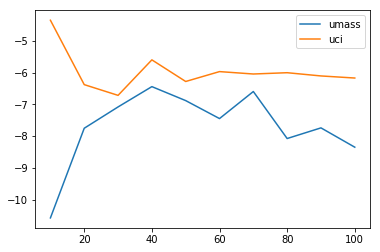

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt

umass = []
uci = []
x = []
for n in sorted(cm_umass.keys()):
    x.append(n)
    umass.append(cm_umass[n].get_coherence())
    uci.append(cm_uci[n].get_coherence())
    
plt.plot(x,umass,label='umass')
plt.plot(x,uci,label='uci')
plt.legend(loc="upper right", title=None)

In [148]:
NUM_TOPICS_BEST = 70
lda_best = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=NUM_TOPICS_BEST)
lda_best.save('../datasets/PhoneComplaints/LDA_'+str(NUM_TOPICS_BEST)+'_TFIDF-phone_complaints.model')

In [149]:
lda_best.show_topics(NUM_TOPICS_BEST)

[(0,
  u'0.005*"etisalat" + 0.004*"medicare" + 0.004*"dhl" + 0.002*"flood" + 0.002*"hunger" + 0.002*"handbag" + 0.002*"actor" + 0.001*"forewarned" + 0.001*"bend" + 0.001*"danny"'),
 (1,
  u'0.012*"headset" + 0.007*"sc" + 0.005*"docket" + 0.005*"voters" + 0.004*"laguna" + 0.004*"underage" + 0.004*"shaw" + 0.004*"ballot" + 0.003*"stayed" + 0.003*"mountain"'),
 (2,
  u'0.012*"jacksonville" + 0.009*"flag" + 0.009*"tn" + 0.009*"treasury" + 0.008*"robotic" + 0.006*"sweepstakes" + 0.006*"morgan" + 0.005*"veteran" + 0.005*"compliant" + 0.005*"statue"'),
 (3,
  u'0.006*"prayer" + 0.004*"laura" + 0.003*"prohibits" + 0.002*"liz" + 0.002*"migration" + 0.002*"dep" + 0.002*"cpc" + 0.001*"migrate" + 0.001*"gail" + 0.001*"geeks"'),
 (4,
  u'0.009*"variations" + 0.008*"dodge" + 0.005*"triple" + 0.005*"experian" + 0.004*"popup" + 0.004*"cel" + 0.004*"bothersome" + 0.003*"donna" + 0.003*"popups" + 0.003*"contracting"'),
 (5,
  u'0.006*"tracfone" + 0.005*"scotia" + 0.005*"je" + 0.004*"le" + 0.004*"et" + 0